<a href="https://colab.research.google.com/github/asu-trans-ai-lab/TAPLite/blob/main/TF_for_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 import pandas as pd
import tensorflow as tf
def parse_gams_input():
    """
    Parses GAMS-style input to extract sets, parameters, and tables.
    Returns cost_matrix, demand_vector, supply_vector, and seed_matrix.
    """
    # Define sets
    plants = ['1', '2']
    markets = ['new-york', 'chicago', 'topeka']

    # Define parameters
    capacity = {'1': 350, '2': 600}
    demand = {'new-york': 325, 'chicago': 300, 'topeka': 275}

    # Define distance table (in thousands of miles)
    distance_data = {
        '1': {'new-york': 2.5, 'chicago': 1.7, 'topeka': 1.8},
        '2': {'new-york': 2.5, 'chicago': 1.8, 'topeka': 1.4}
    }
    distance = pd.DataFrame(distance_data).T

    # Transportation cost per case (distance * cost per thousand miles)
    cost_matrix = distance * 90

    # Create a seed matrix (initialize with an example feasible distribution)
    seed_matrix = pd.DataFrame({
        'new-york': [50, 275],
        'chicago': [300, 0],
        'topeka': [0, 275]
    }, index=plants)

    # Convert to TensorFlow tensors
    cost_matrix = tf.constant(cost_matrix.values, dtype=tf.float32)
    demand_vector = tf.constant([demand[m] for m in markets], dtype=tf.float32)
    supply_vector = tf.constant([capacity[p] for p in plants], dtype=tf.float32)
    seed_matrix = tf.constant(seed_matrix.values, dtype=tf.float32)

    return cost_matrix, demand_vector, supply_vector, seed_matrix
def optimize_transport_with_detailed_logging():
    """
    Optimizes transportation costs with TensorFlow, includes non-negativity penalties, and detailed logs.
    """
    # Parse input
    cost_matrix, demand_vector, supply_vector, seed_matrix = parse_gams_input()

    # Decision variables: Flow matrix (plants x markets) initialized with seed matrix
    OD_flow = tf.Variable(seed_matrix, dtype=tf.float32)

    # Define penalty weights
    gamma = tf.constant(1e3, dtype=tf.float32)  # Non-negativity penalty weight

    # Define objective function
    def objective_function(OD_flow):
        # Transportation cost
        transportation_cost = tf.reduce_sum(cost_matrix * OD_flow)

        # Supply and demand constraints (penalty terms)
        supply_violation = tf.reduce_sum(tf.nn.relu(tf.reduce_sum(OD_flow, axis=1) - supply_vector) ** 2)
        demand_violation = tf.reduce_sum(tf.nn.relu(demand_vector - tf.reduce_sum(OD_flow, axis=0)) ** 2)

        # Non-negativity penalty
        non_negativity_penalty = tf.reduce_sum(gamma * tf.nn.relu(-OD_flow) ** 2)

        # Total objective
        total_cost = transportation_cost + 1e6 * supply_violation + 1e6 * demand_violation + non_negativity_penalty
        return total_cost, transportation_cost

    # Optimizer setup
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

    # Training loop
    for step in range(500):
        with tf.GradientTape() as tape:
            loss, transportation_cost = objective_function(OD_flow)

        # Compute gradients and apply updates
        gradients = tape.gradient(loss, [OD_flow])
        optimizer.apply_gradients(zip(gradients, [OD_flow]))

        # Enforce non-negativity after updates
        OD_flow.assign(tf.maximum(OD_flow, 0.0))

        # Print progress every 100 steps
        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss.numpy()}")
            print(f"Transportation Cost: {transportation_cost.numpy()}")
            print("OD Flow Matrix (by Plant → Market):")
            for plant_idx, plant in enumerate(['1', '2']):
                flows = OD_flow[plant_idx].numpy()
                print(f"  Plant {plant}: New York={flows[0]:.2f}, Chicago={flows[1]:.2f}, Topeka={flows[2]:.2f}")
            print("\n")

    # Final result
    print("Final Optimized Flow Matrix:")
    print(OD_flow.numpy())
    return OD_flow.numpy()

# Run the demonstration
final_result = optimize_transport_with_detailed_logging()
print("Final Optimized Flow Matrix:")
print(final_result)


Step 0, Loss: 153675.0
Transportation Cost: 153675.0
OD Flow Matrix (by Plant → Market):
  Plant 1: New York=49.90, Chicago=299.90, Topeka=0.00
  Plant 2: New York=274.90, Chicago=0.00, Topeka=274.90


Step 100, Loss: 153817.4375
Transportation Cost: 153817.4375
OD Flow Matrix (by Plant → Market):
  Plant 1: New York=49.84, Chicago=299.49, Topeka=0.00
  Plant 2: New York=275.54, Chicago=0.51, Topeka=275.41


Step 200, Loss: 153780.484375
Transportation Cost: 153780.484375
OD Flow Matrix (by Plant → Market):
  Plant 1: New York=49.79, Chicago=299.49, Topeka=0.00
  Plant 2: New York=275.47, Chicago=0.51, Topeka=275.33


Step 300, Loss: 153731.640625
Transportation Cost: 153731.640625
OD Flow Matrix (by Plant → Market):
  Plant 1: New York=49.73, Chicago=299.49, Topeka=0.00
  Plant 2: New York=275.38, Chicago=0.51, Topeka=275.23


Step 400, Loss: 153692.015625
Transportation Cost: 153692.015625
OD Flow Matrix (by Plant → Market):
  Plant 1: New York=49.68, Chicago=299.50, Topeka=0.00
  Pl

# Expected TensorFlow Output

The optimized flow matrix should resemble the GAMS solution:

| Plant → Market | New York | Chicago | Topeka |
|-----------------|----------|---------|--------|
| **1**           | 50       | 300     | 0      |
| **2**           | 275      | 0       | 275    |



In [ ]:
import tensorflow as tf

def optimize_transport_with_backpropagation(cost_matrix, supply, demand, seed_matrix=None):
    """
    Optimizes transportation costs with TensorFlow, using gradient-based optimization.
    Parameters:
        cost_matrix (list of lists): A 2D list representing transportation costs.
        supply (list): A list representing the supply capacity of sources.
        demand (list): A list representing the demand at destinations.
        seed_matrix (list of lists, optional): Initial feasible solution for the flow matrix.
            Defaults to a zero matrix of appropriate dimensions.
    Returns:
        final_flow (numpy.ndarray): The optimized flow matrix.
        final_cost (float): The total optimized transportation cost.
    """
    # Parse input data
    cost_tensor, supply_tensor, demand_tensor, seed_tensor = parse_input(
        cost_matrix, supply, demand, seed_matrix
    )

    # Decision variable: Flow matrix
    OD_flow = tf.Variable(seed_tensor, dtype=tf.float32)

    # Define penalty weights
    gamma = tf.constant(1e3, dtype=tf.float32)  # Non-negativity penalty weight
    constraint_penalty = tf.constant(1e6, dtype=tf.float32)  # Constraint violation penalty

    # Define objective function
    def objective_function(OD_flow):
        # Transportation cost
        transportation_cost = tf.reduce_sum(cost_tensor * OD_flow)

        # Penalty for supply and demand constraints
        supply_violation = tf.reduce_sum(tf.nn.relu(tf.reduce_sum(OD_flow, axis=1) - supply_tensor) ** 2)
        demand_violation = tf.reduce_sum(tf.nn.relu(demand_tensor - tf.reduce_sum(OD_flow, axis=0)) ** 2)

        # Penalty for non-negativity
        non_negativity_penalty = tf.reduce_sum(gamma * tf.nn.relu(-OD_flow) ** 2)

        # Total objective
        total_cost = (
            transportation_cost
            + constraint_penalty * (supply_violation + demand_violation)
            + non_negativity_penalty
        )
        return total_cost, transportation_cost

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

    # Training loop
    for step in range(1000):
        with tf.GradientTape() as tape:
            loss, transportation_cost = objective_function(OD_flow)

        # Compute gradients and apply updates
        gradients = tape.gradient(loss, [OD_flow])
        optimizer.apply_gradients(zip(gradients, [OD_flow]))

        # Enforce non-negativity constraint
        OD_flow.assign(tf.maximum(OD_flow, 0.0))

        # Log progress every 100 steps
        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss.numpy():.2f}, Transportation Cost: {transportation_cost.numpy():.2f}")

    # Final results
    final_flow = OD_flow.numpy()
    final_cost = objective_function(OD_flow)[1].numpy()
    print("Final Optimized Flow Matrix:")
    print(final_flow)
    print(f"Final Transportation Cost: {final_cost:.2f}")
    return final_flow, final_cost

# Example Usage
cost_matrix = [
    [2.5, 1.7, 1.8],  # Costs from plant 1
    [2.5, 1.8, 1.4]   # Costs from plant 2
]
supply = [350, 600]  # Supply capacity of plants
demand = [325, 300, 275]  # Demand at markets
seed_matrix = [
    [50, 300, 0],  # Initial feasible flow from plant 1
    [275, 0, 275]  # Initial feasible flow from plant 2
]

# Run optimization
final_result, total_cost = optimize_transport_with_backpropagation(cost_matrix, supply, demand, seed_matrix)

print("\nOptimized Flow Matrix:")
print(final_result)
print(f"Total Transportation Cost: {total_cost:.2f}")



Step 0, Loss: 1707.50, Transportation Cost: 1707.50
Step 100, Loss: 1709.40, Transportation Cost: 1709.40
Step 200, Loss: 1709.40, Transportation Cost: 1709.40
Step 300, Loss: 1709.39, Transportation Cost: 1709.39
Step 400, Loss: 1709.39, Transportation Cost: 1709.39
Step 500, Loss: 1709.38, Transportation Cost: 1709.38
Step 600, Loss: 1709.36, Transportation Cost: 1709.36
Step 700, Loss: 1709.34, Transportation Cost: 1709.34
Step 800, Loss: 1709.32, Transportation Cost: 1709.32
Step 900, Loss: 1709.30, Transportation Cost: 1709.30
Final Optimized Flow Matrix:
[[ 49.858463   299.5061       0.        ]
 [275.5575       0.53359085 275.4367    ]]
Final Transportation Cost: 1709.27

Optimized Flow Matrix:
[[ 49.858463   299.5061       0.        ]
 [275.5575       0.53359085 275.4367    ]]
Total Transportation Cost: 1709.27


In [ ]:
import tensorflow as tf

def optimize_transport_with_marginals(cost_matrix, supply, demand, seed_matrix=None):
    """
    Optimizes transportation costs and prints marginal values for supply and demand constraints.
    Parameters:
        cost_matrix (list of lists): Transportation costs.
        supply (list): Supply capacity at sources.
        demand (list): Demand at destinations.
        seed_matrix (list of lists, optional): Initial feasible flow matrix.
            Defaults to a zero matrix of appropriate dimensions.
    Returns:
        final_flow (numpy.ndarray): Optimized flow matrix.
        final_cost (float): Total transportation cost.
        supply_marginals (list): Marginal values for supply constraints.
        demand_marginals (list): Marginal values for demand constraints.
    """
    # Parse input data
    cost_tensor, _, _, seed_tensor = parse_input(cost_matrix, supply, demand, seed_matrix)

    # Convert supply and demand to variables for gradient tracking
    supply_tensor = tf.constant(supply, dtype=tf.float32)
    demand_tensor = tf.constant(demand, dtype=tf.float32)

    # Decision variable: Flow matrix
    OD_flow = tf.Variable(seed_tensor, dtype=tf.float32)

    # Define penalty weights
    gamma = tf.constant(1e3, dtype=tf.float32)  # Non-negativity penalty weight
    constraint_penalty = tf.constant(1e6, dtype=tf.float32)  # Constraint violation penalty

    # Define objective function
    def objective_function(OD_flow):
        # Transportation cost
        transportation_cost = tf.reduce_sum(cost_tensor * OD_flow)

        # Supply and demand constraint violations
        supply_violation = tf.reduce_sum(tf.nn.relu(tf.reduce_sum(OD_flow, axis=1) - supply_tensor) ** 2)
        demand_violation = tf.reduce_sum(tf.nn.relu(demand_tensor - tf.reduce_sum(OD_flow, axis=0)) ** 2)

        # Non-negativity penalty
        non_negativity_penalty = tf.reduce_sum(gamma * tf.nn.relu(-OD_flow) ** 2)

        # Total objective
        total_cost = (
            transportation_cost
            + constraint_penalty * (supply_violation + demand_violation)
            + non_negativity_penalty
        )
        return total_cost, transportation_cost

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

import tensorflow as tf

def optimize_transport_with_marginals(cost_matrix, supply, demand, seed_matrix=None):
    """
    Optimizes transportation costs and prints marginal values for supply and demand constraints.
    Parameters:
        cost_matrix (list of lists): Transportation costs.
        supply (list): Supply capacity at sources.
        demand (list): Demand at destinations.
        seed_matrix (list of lists, optional): Initial feasible flow matrix.
            Defaults to a zero matrix of appropriate dimensions.
    Returns:
        final_flow (numpy.ndarray): Optimized flow matrix.
        final_cost (float): Total transportation cost.
        supply_marginals (list): Marginal values for supply constraints.
        demand_marginals (list): Marginal values for demand constraints.
    """
    # Parse input data
    cost_tensor, _, _, seed_tensor = parse_input(cost_matrix, supply, demand, seed_matrix)

    # Convert supply and demand to tensors
    supply_tensor = tf.constant(supply, dtype=tf.float32)
    demand_tensor = tf.constant(demand, dtype=tf.float32)

    # Decision variable: Flow matrix
    OD_flow = tf.Variable(seed_tensor, dtype=tf.float32)

    # Define penalty weights
    gamma = tf.constant(1e3, dtype=tf.float32)  # Non-negativity penalty weight
    constraint_penalty = tf.constant(1e6, dtype=tf.float32)  # Constraint violation penalty

    # Define objective function
    def objective_function(OD_flow):
        # Transportation cost
        transportation_cost = tf.reduce_sum(cost_tensor * OD_flow)

        # Supply and demand constraint violations
        supply_violation = tf.reduce_sum(tf.nn.relu(tf.reduce_sum(OD_flow, axis=1) - supply_tensor))
        demand_violation = tf.reduce_sum(tf.nn.relu(demand_tensor - tf.reduce_sum(OD_flow, axis=0)))

        # Non-negativity penalty
        non_negativity_penalty = tf.reduce_sum(gamma * tf.nn.relu(-OD_flow) ** 2)

        # Total objective
        total_cost = (
            transportation_cost
            + constraint_penalty * (supply_violation + demand_violation)
            + non_negativity_penalty
        )
        return total_cost, transportation_cost, supply_violation, demand_violation

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

    # Training loop
    for step in range(500):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(OD_flow)
            loss, transportation_cost, supply_violation, demand_violation = objective_function(OD_flow)

        # Compute gradients and apply updates
        gradients = tape.gradient(loss, [OD_flow])
        optimizer.apply_gradients(zip(gradients, [OD_flow]))

        # Enforce non-negativity constraint
        OD_flow.assign(tf.maximum(OD_flow, 0.0))

        # Extract marginal values (gradients of constraint violations w.r.t. flow matrix)
        supply_gradient = tape.gradient(supply_violation, [OD_flow])[0]
        demand_gradient = tape.gradient(demand_violation, [OD_flow])[0]

        # Log progress and marginal values every 100 steps
        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss.numpy():.2f}, Transportation Cost: {transportation_cost.numpy():.2f}")
            print(f"Supply Marginals: {tf.reduce_sum(supply_gradient, axis=1).numpy()}")
            print(f"Demand Marginals: {tf.reduce_sum(demand_gradient, axis=0).numpy()}")

    # Final results
    final_flow = OD_flow.numpy()
    final_cost = transportation_cost.numpy()
    supply_marginals = tf.reduce_sum(supply_gradient, axis=1).numpy()
    demand_marginals = tf.reduce_sum(demand_gradient, axis=0).numpy()

    print("Final Optimized Flow Matrix:")
    print(final_flow)
    print(f"Final Transportation Cost: {final_cost:.2f}")
    return final_flow, final_cost, supply_marginals, demand_marginals

# Example Usage
cost_matrix = [
    [2.5 * 90, 1.7 * 90, 1.8 * 90],  # Costs from plant 1
    [2.5 * 90, 1.8 * 90, 1.4 * 90]   # Costs from plant 2
]
supply = [350, 600]  # Supply capacity of plants
demand = [325, 300, 275]  # Demand at markets
seed_matrix = [
    [50, 300, 0],  # Initial feasible flow from plant 1
    [275, 0, 275]  # Initial feasible flow from plant 2
]

# Run optimization
final_result, total_cost, supply_marginals, demand_marginals = optimize_transport_with_marginals(
    cost_matrix, supply, demand, seed_matrix
)

# Display results
print("\nOptimized Flow Matrix:")
print(final_result)
print(f"Total Transportation Cost: {total_cost:.2f}")
print(f"Final Supply Marginals: {supply_marginals}")
print(f"Final Demand Marginals: {demand_marginals}")


Step 0, Loss: 153675.00, Transportation Cost: 153675.00
Supply Marginals: [0. 0.]
Demand Marginals: [0. 0. 0.]
Step 100, Loss: 153906.16, Transportation Cost: 153906.16
Supply Marginals: [0. 0.]
Demand Marginals: [0. 0. 0.]
Step 200, Loss: 153890.05, Transportation Cost: 153890.05
Supply Marginals: [0. 0.]
Demand Marginals: [0. 0. 0.]
Step 300, Loss: 153868.66, Transportation Cost: 153868.66
Supply Marginals: [0. 0.]
Demand Marginals: [0. 0. 0.]
Step 400, Loss: 153842.62, Transportation Cost: 153842.62
Supply Marginals: [0. 0.]
Demand Marginals: [0. 0. 0.]
Final Optimized Flow Matrix:
[[ 49.700314  300.1301      0.       ]
 [275.56473     1.3152736 275.35446  ]]
Final Transportation Cost: 154038.47

Optimized Flow Matrix:
[[ 49.700314  300.1301      0.       ]
 [275.56473     1.3152736 275.35446  ]]
Total Transportation Cost: 154038.47
Final Supply Marginals: [3. 0.]
Final Demand Marginals: [0. 0. 0.]


In [ ]:
import tensorflow as tf

def optimize_transport_with_separate_marginals(cost_matrix, supply, demand, seed_matrix=None):
    """
    Optimizes transportation costs and computes separate marginal values for constraints.
    Parameters:
        cost_matrix (list of lists): Transportation costs.
        supply (list): Supply capacity at sources.
        demand (list): Demand at destinations.
        seed_matrix (list of lists, optional): Initial feasible flow matrix.
            Defaults to a zero matrix of appropriate dimensions.
    Returns:
        final_flow (numpy.ndarray): Optimized flow matrix.
        final_cost (float): Total transportation cost.
        supply_marginals (list): Marginal values for supply constraints.
        demand_marginals (list): Marginal values for demand constraints.
    """
    # Parse input data
    cost_tensor, _, _, seed_tensor = parse_input(cost_matrix, supply, demand, seed_matrix)

    # Convert supply and demand to tensors
    supply_tensor = tf.constant(supply, dtype=tf.float32)
    demand_tensor = tf.constant(demand, dtype=tf.float32)

    # Decision variable: Flow matrix
    OD_flow = tf.Variable(seed_tensor, dtype=tf.float32)

    # Define penalty weights
    gamma = tf.constant(1e3, dtype=tf.float32)  # Non-negativity penalty weight
    constraint_penalty = tf.constant(1e6, dtype=tf.float32)  # High penalty for constraints

    # Define objective function
    def objective_function(OD_flow):
        # Transportation cost
        transportation_cost = tf.reduce_sum(cost_tensor * OD_flow)

        # Supply and demand constraint violations
        supply_violation = tf.reduce_sum(tf.nn.relu(tf.reduce_sum(OD_flow, axis=1) - supply_tensor))
        demand_violation = tf.reduce_sum(tf.nn.relu(demand_tensor - tf.reduce_sum(OD_flow, axis=0)))

        # Non-negativity penalty
        non_negativity_penalty = tf.reduce_sum(gamma * tf.nn.relu(-OD_flow) ** 2)

        # Total objective
        total_cost = (
            transportation_cost
            + constraint_penalty * (supply_violation + demand_violation)
            + non_negativity_penalty
        )
        return total_cost, transportation_cost

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

    # Training loop
    for step in range(500):
        with tf.GradientTape() as tape:
            loss, transportation_cost = objective_function(OD_flow)

        # Compute gradients and apply updates
        gradients = tape.gradient(loss, [OD_flow])
        optimizer.apply_gradients(zip(gradients, [OD_flow]))

        # Enforce non-negativity constraint
        OD_flow.assign(tf.maximum(OD_flow, 0.0))

        # Log progress every 100 steps
        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss.numpy():.2f}, Transportation Cost: {transportation_cost.numpy():.2f}")

    # Final optimization results
    final_flow = OD_flow.numpy()
    final_cost = transportation_cost.numpy()

    # Separate marginal calculations for constraints
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(OD_flow)

        # Recompute constraint violations
        supply_violation = tf.reduce_sum(tf.nn.relu(tf.reduce_sum(OD_flow, axis=1) - supply_tensor))
        demand_violation = tf.reduce_sum(tf.nn.relu(demand_tensor - tf.reduce_sum(OD_flow, axis=0)))

    # Marginal values for supply and demand constraints
    supply_marginals = tape.gradient(supply_violation, [OD_flow])[0]
    demand_marginals = tape.gradient(demand_violation, [OD_flow])[0]

    # Summarize marginal values by sources (supply) and destinations (demand)
    supply_marginals_summary = tf.reduce_sum(supply_marginals, axis=1).numpy()
    demand_marginals_summary = tf.reduce_sum(demand_marginals, axis=0).numpy()

    print("Final Optimized Flow Matrix:")
    print(final_flow)
    print(f"Final Transportation Cost: {final_cost:.2f}")
    return final_flow, final_cost, supply_marginals_summary, demand_marginals_summary

# Example Usage
cost_matrix = [
    [2.5 * 90, 1.7 * 90, 1.8 * 90],  # Costs from plant 1
    [2.5 * 90, 1.8 * 90, 1.4 * 90]   # Costs from plant 2
]
supply = [350, 600]  # Supply capacity of plants
demand = [325, 300, 275]  # Demand at markets
seed_matrix = [
    [50, 300, 0],  # Initial feasible flow from plant 1
    [275, 0, 275]  # Initial feasible flow from plant 2
]

# Run optimization
final_result, total_cost, supply_marginals, demand_marginals = optimize_transport_with_separate_marginals(
    cost_matrix, supply, demand, seed_matrix
)

# Display results
print("\nOptimized Flow Matrix:")
print(final_result)
print(f"Total Transportation Cost: {total_cost:.2f}")
print(f"Final Supply Marginals: {supply_marginals}")
print(f"Final Demand Marginals: {demand_marginals}")


Step 0, Loss: 153675.00, Transportation Cost: 153675.00
Step 100, Loss: 153906.16, Transportation Cost: 153906.16
Step 200, Loss: 153890.05, Transportation Cost: 153890.05
Step 300, Loss: 153868.66, Transportation Cost: 153868.66
Step 400, Loss: 153842.62, Transportation Cost: 153842.62
Final Optimized Flow Matrix:
[[ 49.700314  300.1301      0.       ]
 [275.56473     1.3152736 275.35446  ]]
Final Transportation Cost: 154038.47

Optimized Flow Matrix:
[[ 49.700314  300.1301      0.       ]
 [275.56473     1.3152736 275.35446  ]]
Total Transportation Cost: 154038.47
Final Supply Marginals: [0. 0.]
Final Demand Marginals: [0. 0. 0.]


In [ ]:
import tensorflow as tf

# Assuming `final_result` is the optimized flow matrix (as a NumPy array)
# and `cost_matrix` is already defined as a TensorFlow tensor

# Convert `final_result` to TensorFlow tensor
final_result_tensor = tf.constant(final_result, dtype=tf.float32)

# Compute the transportation cost
transportation_cost = tf.reduce_sum(cost_matrix * final_result_tensor)

# Print the transportation cost
print(f"Transportation Cost (recomputed): {transportation_cost.numpy():.2f}")

Transportation Cost (recomputed): 1709.27


# Extracted Information from the Image

## OD Pairs
1. (1, 3)  
2. (1, 4)  
3. (2, 3)  
4. (2, 4)  

---

## Paths
- **Path 1**: (1 → 5 → 6 → 3)  
- **Path 2**: (1 → 5 → 6 → 4)  
- **Path 3**: (2 → 5 → 6 → 3)  
- **Path 4**: (2 → 5 → 6 → 4)  
- **Path 5**: (2 → 4)  

---

## Links
- **Link a**  
- **Link b**  
- **Link c**  

---

## Matrices
1. **OD-to-path assignment matrix** \(B_{OD, P}\):  
   - **Dimension**: \(4 \times 5\)  

2. **Path-to-link incidence matrix** \(A_{PL}\):  
   - **Dimension**: \(5 \times 3\)  

3. **OD-to-link matrix** \(C_{OD, L}\):  
   - **Computed as** \(B_{OD, P}^T \times A_{PL}\)


In [ ]:
import tensorflow as tf

def system_optimal_assignment_with_constraints(B_OD_P, A_PL, f_OD, t_0, capacity, alpha=0.15, beta=4.0, num_steps=500, lr=0.1):
    """
    Solve the system optimal traffic assignment problem with enforced OD flow constraints.

    Args:
    - B_OD_P: OD-to-path assignment matrix (Tensor of shape [num_OD, num_paths]).
    - A_PL: Path-to-link incidence matrix (Tensor of shape [num_paths, num_links]).
    - f_OD: OD demand vector (Tensor of shape [num_OD]).
    - t_0: Free-flow travel times on links (Tensor of shape [num_links]).
    - capacity: Link capacities (Tensor of shape [num_links]).
    - alpha: Parameter for volume-delay function (default: 0.15).
    - beta: Parameter for volume-delay function (default: 4.0).
    - num_steps: Number of optimization steps.
    - lr: Learning rate for the optimizer.

    Returns:
    - f_P: Optimized path flows (Tensor of shape [num_paths]).
    - f_L: Link flows (Tensor of shape [num_links]).
    - T_L: Link travel times (Tensor of shape [num_links]).
    - T_P: Path travel times (Tensor of shape [num_paths]).
    """
    # Initialize path flows as trainable variables
    num_paths = tf.shape(B_OD_P)[1]
    f_P = tf.Variable(tf.zeros(num_paths, dtype=tf.float32), trainable=True)

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # Training loop
    for step in range(num_steps):
        with tf.GradientTape() as tape:
            # Compute link flows (f_L = A_PL^T * f_P)
            f_L = tf.linalg.matvec(tf.transpose(A_PL), f_P)

            # Compute link travel times (T_L = t_0 * (1 + alpha * (f_L / capacity)^beta))
            T_L = t_0 * (1 + alpha * (f_L / capacity) ** beta)

            # Compute path travel times (T_P = A_PL * T_L)
            T_P = tf.linalg.matvec(A_PL, T_L)

            # Total travel time objective (minimize sum(f_P * T_P))
            total_travel_time = tf.reduce_sum(f_P * T_P)

        # Compute and apply gradients
        gradients = tape.gradient(total_travel_time, [f_P])
        optimizer.apply_gradients(zip(gradients, [f_P]))

        # Enforce non-negativity
        f_P.assign(tf.maximum(f_P, 0.0))

        # Enforce OD flow constraints (projection step)
        f_P.assign(tf.linalg.matvec(tf.transpose(B_OD_P), f_OD))

        # Log progress every 100 steps
        if step % 100 == 0 or step == num_steps - 1:
            deviation_f_OD = tf.reduce_sum(tf.square(tf.linalg.matvec(tf.transpose(B_OD_P), f_OD) - f_P)).numpy()
            print(f"Step {step}, Total Travel Time: {total_travel_time.numpy():.2f}")
            print(f"Deviation (OD Flow): {deviation_f_OD:.4f}")

    # Final results
    f_L = tf.linalg.matvec(tf.transpose(A_PL), f_P)
    T_L = t_0 * (1 + alpha * (f_L / capacity) ** beta)
    T_P = tf.linalg.matvec(A_PL, T_L)

    return f_P.numpy(), f_L.numpy(), T_L.numpy(), T_P.numpy()


# Example Input Data
B_OD_P = tf.constant([
    [1, 0, 0, 0, 0],  # (1,3)
    [0, 1, 0, 0, 0],  # (1,4)
    [0, 0, 1, 0, 0],  # (2,3)
    [0, 0, 0, 0.3, 0.7]  # (2,4)
], dtype=tf.float32)

A_PL = tf.constant([
    [1, 1, 0],  # Path 1
    [1, 1, 0],  # Path 2
    [0, 1, 1],  # Path 3
    [0, 1, 1],  # Path 4
    [0, 0, 1]   # Path 5
], dtype=tf.float32)

f_OD = tf.constant([4000.0, 1000.0, 2000.0, 2000.0], dtype=tf.float32)  # OD volumes
t_0 = tf.constant([15.0, 18.0, 10.0], dtype=tf.float32)  # Free-flow travel times for links
capacity = tf.constant([5000.0, 8000.0, 3000.0], dtype=tf.float32)  # Link capacities

# Solve the system optimal problem with enforced constraints
f_P, f_L, T_L, T_P = system_optimal_assignment_with_constraints(
    B_OD_P, A_PL, f_OD, t_0, capacity
)

# Print final results
print("\nOptimized Path Flows (f_P):", f_P)
print("Link Flows (f_L):", f_L)
print("Link Travel Times (T_L):", T_L)
print("Path Travel Times (T_P):", T_P)



Step 0, Total Travel Time: 0.00
Deviation (OD Flow): 0.0000
Step 100, Total Travel Time: 298726.59
Deviation (OD Flow): 0.0000
Step 200, Total Travel Time: 298726.59
Deviation (OD Flow): 0.0000
Step 300, Total Travel Time: 298726.59
Deviation (OD Flow): 0.0000
Step 400, Total Travel Time: 298726.59
Deviation (OD Flow): 0.0000
Step 499, Total Travel Time: 298726.59
Deviation (OD Flow): 0.0000

Optimized Path Flows (f_P): [4000. 1000. 2000.  600. 1400.]
Link Flows (f_L): [5000. 7600. 4000.]
Link Travel Times (T_L): [17.25     20.199167 14.740742]
Path Travel Times (T_P): [37.449165 37.449165 34.93991  34.93991  14.740742]


olution: Constraint Projection
Projection onto the Feasible Region: After each gradient step, we ensure that the path flows
f
P
f
P
​
  satisfy:

B
O
D
,
P
T
⋅
f
O
D
=
f
P
B
OD,P
T
​
 ⋅f
OD
​
 =f
P
​

This is done by directly solving for
f
P
f
P
​
  using the known
f
O
D
f
OD
​
  and
B
O
D
,
P
B
OD,P
​
 .

Modify the Optimization Process:

After every update of
f
P
f
P
​
 , project
f
P
f
P
​
  onto the feasible region by solving:
f
P
=
B
O
D
,
P
T
⋅
f
O
D
f
P
​
 =B
OD,P
T
​
 ⋅f
OD
​

This guarantees that the OD flow constraints are strictly enforced at all times.
Implementation: Incorporate the projection step directly into the training loop.

In [ ]:
import tensorflow as tf

def traffic_assignment(path_flow, delta, t_0, capacity, alpha=0.15, beta=4.0):
    """
    Tensor-based traffic assignment from path flow to link flow, link travel time, and path travel time.

    Args:
    - path_flow: Tensor of shape [num_paths], flow on each path.
    - delta: Tensor of shape [num_links, num_paths], link-path incidence matrix.
    - t_0: Tensor of shape [num_links], free-flow travel time for each link.
    - capacity: Tensor of shape [num_links], capacity of each link.
    - alpha: Parameter for the volume-delay function (default: 0.15).
    - beta: Parameter for the volume-delay function (default: 4.0).

    Returns:
    - link_flow: Tensor of shape [num_links], flow on each link.
    - link_travel_time: Tensor of shape [num_links], travel time on each link.
    - path_travel_time: Tensor of shape [num_paths], travel time on each path.
    """
    # Path Flow to Link Flow
    link_flow = tf.linalg.matvec(delta, path_flow)  # f = delta x

    # Link Flow to Link Travel Time (Volume-Delay Function)
    link_travel_time = t_0 * (1 + alpha * (link_flow / capacity) ** beta)

    # Link Travel Time to Path Travel Time
    path_travel_time = tf.linalg.matvec(tf.transpose(delta), link_travel_time)  # T = delta^T t

    return link_flow, link_travel_time, path_travel_time

# Example Usage
num_links = 4
num_paths = 3

# Example inputs
path_flow = tf.constant([100.0, 200.0, 150.0], dtype=tf.float32)  # Flow on paths
delta = tf.constant([[1, 0, 1],  # Link 1
                     [1, 1, 0],  # Link 2
                     [0, 1, 1],  # Link 3
                     [0, 0, 1]], dtype=tf.float32)  # Link 4
t_0 = tf.constant([10.0, 15.0, 12.0, 20.0], dtype=tf.float32)  # Free-flow travel times
capacity = tf.constant([100.0, 150.0, 120.0, 180.0], dtype=tf.float32)  # Link capacities

# Run traffic assignment
link_flow, link_travel_time, path_travel_time = traffic_assignment(path_flow, delta, t_0, capacity)

# Print results
print("Link Flow:", link_flow.numpy())
print("Link Travel Time:", link_travel_time.numpy())
print("Path Travel Time:", path_travel_time.numpy())


Link Flow: [250. 300. 350. 150.]
Link Travel Time: [ 68.59375  51.      142.2626   21.44676]
Path Travel Time: [119.59375 193.2626  232.30312]


In [ ]:
import tensorflow as tf

# Input Matrices for the Sample Network
A_PL = tf.constant([
    [1, 1, 0],  # Path 1
    [1, 1, 1],  # Path 2
    [0, 1, 0],  # Path 3
    [0, 1, 1],  # Path 4
    [0, 0, 1],  # Path 5
], dtype=tf.float32)

B_OD_P = tf.constant([
    [1, 0, 0, 0, 0],  # (1,3)
    [0, 1, 0, 0, 0],  # (1,4)
    [0, 0, 1, 0, 0],  # (2,3)
    [0, 0, 0, 0.3, 0.7],  # (2,4)
], dtype=tf.float32)

# Supply (Demand) for each OD Pair
f_OD_supply = tf.constant([4000.0, 1000.0, 2000.0, 2000.0], dtype=tf.float32)  # (1,3), (1,4), (2,3), (2,4)

# Free-flow Travel Times for Links (a, b, c)
T_L_0 = tf.constant([10.0, 15.0, 5.0], dtype=tf.float32)

# Link Capacities for Links (a, b, c)
C_L = tf.constant([5000.0, 8000.0, 3000.0], dtype=tf.float32)

# BPR Parameters
alpha = 0.15
beta = 4.0

# Penalty Weight for Supply Equality
penalty_weight = 1e4

# Initialize Path Flows (Decision Variable)
f_P = tf.Variable(tf.ones([5], dtype=tf.float32))  # Path flows for paths 1, 2, 3, 4, 5

# Objective Function
def objective_function():
    # Step 1: Compute OD Flows
    f_OD = tf.matmul(B_OD_P, tf.expand_dims(f_P, axis=1))[:, 0]  # OD Flows from Path Flows

    # Step 2: Compute Link Flows
    f_L = tf.matmul(tf.transpose(A_PL), tf.expand_dims(f_P, axis=1))[:, 0]  # Transposed A_PL

    # Step 3: Compute Link Travel Times (BPR Function)
    T_L = T_L_0 * (1 + alpha * (f_L / C_L) ** beta)

    # Step 4: Compute Path Travel Times
    T_P = tf.matmul(A_PL, tf.expand_dims(T_L, axis=1))[:, 0]  # Path Travel Times from Link Travel Times

    # Step 5: Compute OD Travel Times
    T_OD = tf.matmul(B_OD_P, tf.expand_dims(T_P, axis=1))[:, 0]  # OD Travel Times from Path Travel Times

    # Total Travel Time
    total_travel_time = tf.reduce_sum(f_OD * T_OD)

    # Supply Equality Penalty
    supply_penalty = tf.reduce_sum((f_OD - f_OD_supply) ** 2)

    # Objective: Minimize Total Travel Time + Supply Equality Penalty
    return total_travel_time + penalty_weight * supply_penalty

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

# Training Loop
for step in range(500):
    with tf.GradientTape() as tape:
        loss = objective_function()
    gradients = tape.gradient(loss, [f_P])
    optimizer.apply_gradients(zip(gradients, [f_P]))

    # Enforce Non-Negativity
    f_P.assign(tf.maximum(f_P, 0.0))

    # Logging every 100 steps
    if step % 100 == 0:
        f_OD = tf.matmul(B_OD_P, tf.expand_dims(f_P, axis=1))[:, 0].numpy()  # Compute OD Flows
        print(f"Step {step}, Loss: {loss.numpy()}")
        print(f"Path Flows: {f_P.numpy()}")
        print(f"OD Flows: {f_OD}")
        print()

# Final Results
f_OD = tf.matmul(B_OD_P, tf.expand_dims(f_P, axis=1))[:, 0].numpy()
print("Final Path Flows:", f_P.numpy())
print("Final OD Flows:", f_OD)



Step 0, Loss: 249820037120.0
Path Flows: [1.0999993 1.0999993 1.0999993 1.0999993 1.0999993]
OD Flows: [1.0999993 1.0999993 1.0999993 1.0999993]

Step 100, Loss: 248026202112.0
Path Flows: [11.095604 11.082561 11.091267 11.091266 11.091266]
OD Flows: [11.095604 11.082561 11.091267 11.091266]

Step 200, Loss: 246244065280.0
Path Flows: [21.079449 21.017815 21.058964 21.058962 21.058962]
OD Flows: [21.079449 21.017815 21.058964 21.058962]

Step 300, Loss: 244473577472.0
Path Flows: [31.051598 30.905787 31.003183 31.003183 31.003183]
OD Flows: [31.051598 30.905787 31.003183 31.003185]

Step 400, Loss: 242714525696.0
Path Flows: [41.012447 40.74784  40.924675 40.924675 40.92468 ]
OD Flows: [41.012447 40.74784  40.924675 40.924675]

Final Path Flows: [50.862934 50.447548 50.725304 50.7253   50.725304]
Final OD Flows: [50.862934 50.447548 50.725304 50.725304]


Step 0, Loss: 23320000987136.00, Total Travel Time: 0.00
Deviation (OD Flow): 23318200.0000
Step 100, Loss: 23140669325312.00, Total Travel Time: 1318.14
Deviation (OD Flow): 23138880.0000
Step 200, Loss: 22962797281280.00, Total Travel Time: 2631.13
Deviation (OD Flow): 22961028.0000
Step 300, Loss: 22786378563584.00, Total Travel Time: 3938.96
Deviation (OD Flow): 22784620.0000
Step 400, Loss: 22611381714944.00, Total Travel Time: 5241.77
Deviation (OD Flow): 22609638.0000
Step 499, Loss: 22439513817088.00, Total Travel Time: 6526.75
Deviation (OD Flow): 22437784.0000

Optimized Path Flows (f_P): [49.862957 49.44809  49.72546  49.073547 49.606956]
Link Flows (f_L): [ 99.31105 198.11006 148.40598]
Link Travel Times (T_L): [15.      18.      10.00001]
Path Travel Times (T_P): [33.      33.      28.00001 28.00001 10.00001]


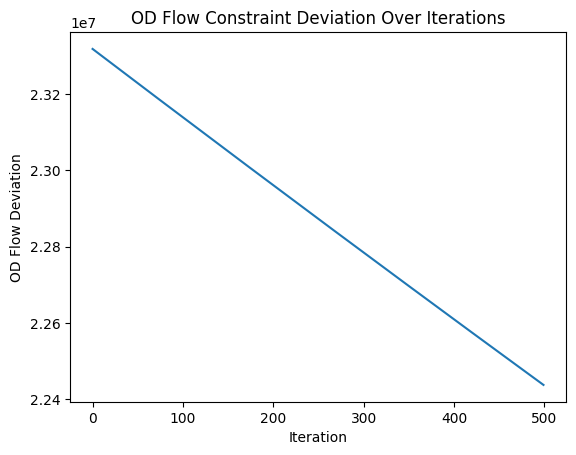

In [ ]:
import tensorflow as tf

def system_optimal_assignment_with_penalty(B_OD_P, A_PL, f_OD, t_0, capacity, alpha=0.15, beta=4.0, num_steps=500, lr=0.1, penalty_weight=1e6):
    """
    Solve the system optimal traffic assignment problem using penalty-based enforcement of OD flow constraints.

    Args:
    - B_OD_P: OD-to-path assignment matrix (Tensor of shape [num_OD, num_paths]).
    - A_PL: Path-to-link incidence matrix (Tensor of shape [num_paths, num_links]).
    - f_OD: OD demand vector (Tensor of shape [num_OD]).
    - t_0: Free-flow travel times on links (Tensor of shape [num_links]).
    - capacity: Link capacities (Tensor of shape [num_links]).
    - alpha: Parameter for volume-delay function (default: 0.15).
    - beta: Parameter for volume-delay function (default: 4.0).
    - num_steps: Number of optimization steps.
    - lr: Learning rate for the optimizer.
    - penalty_weight: Penalty weight for OD flow constraints (default: 1e6).

    Returns:
    - f_P: Optimized path flows (Tensor of shape [num_paths]).
    - f_L: Link flows (Tensor of shape [num_links]).
    - T_L: Link travel times (Tensor of shape [num_links]).
    - T_P: Path travel times (Tensor of shape [num_paths]).
    - deviations: List of OD flow constraint deviations over iterations.
    """
    # Initialize path flows as trainable variables
    num_paths = tf.shape(B_OD_P)[1]
    f_P = tf.Variable(tf.zeros(num_paths, dtype=tf.float32), trainable=True)

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # Deviation log
    deviations = []

    # Training loop
    for step in range(num_steps):
        with tf.GradientTape() as tape:
            # Compute link flows (f_L = A_PL^T * f_P)
            f_L = tf.linalg.matvec(tf.transpose(A_PL), f_P)

            # Compute link travel times (T_L = t_0 * (1 + alpha * (f_L / capacity)^beta))
            T_L = t_0 * (1 + alpha * (f_L / capacity) ** beta)

            # Compute path travel times (T_P = A_PL * T_L)
            T_P = tf.linalg.matvec(A_PL, T_L)

            # Total travel time objective (minimize sum(f_P * T_P))
            total_travel_time = tf.reduce_sum(f_P * T_P)

            # OD flow constraint penalty (||B_OD,P^T * f_OD - f_P||^2)
            od_constraint_violation = tf.reduce_sum(tf.square(tf.linalg.matvec(tf.transpose(B_OD_P), f_OD) - f_P))

            # Loss = total travel time + penalty for OD constraint violations
            loss = total_travel_time + penalty_weight * od_constraint_violation

        # Compute and apply gradients
        gradients = tape.gradient(loss, [f_P])
        optimizer.apply_gradients(zip(gradients, [f_P]))

        # Enforce non-negativity
        f_P.assign(tf.maximum(f_P, 0.0))

        # Log deviation for OD flow constraint
        deviation = tf.reduce_sum(tf.square(tf.linalg.matvec(tf.transpose(B_OD_P), f_OD) - f_P)).numpy()
        deviations.append(deviation)

        # Log progress every 100 steps
        if step % 100 == 0 or step == num_steps - 1:
            print(f"Step {step}, Loss: {loss.numpy():.2f}, Total Travel Time: {total_travel_time.numpy():.2f}")
            print(f"Deviation (OD Flow): {deviation:.4f}")

    # Final results
    f_L = tf.linalg.matvec(tf.transpose(A_PL), f_P)
    T_L = t_0 * (1 + alpha * (f_L / capacity) ** beta)
    T_P = tf.linalg.matvec(A_PL, T_L)

    return f_P.numpy(), f_L.numpy(), T_L.numpy(), T_P.numpy(), deviations


# Example Input Data
B_OD_P = tf.constant([
    [1, 0, 0, 0, 0],  # (1,3)
    [0, 1, 0, 0, 0],  # (1,4)
    [0, 0, 1, 0, 0],  # (2,3)
    [0, 0, 0, 0.3, 0.7]  # (2,4)
], dtype=tf.float32)

A_PL = tf.constant([
    [1, 1, 0],  # Path 1
    [1, 1, 0],  # Path 2
    [0, 1, 1],  # Path 3
    [0, 1, 1],  # Path 4
    [0, 0, 1]   # Path 5
], dtype=tf.float32)

f_OD = tf.constant([4000.0, 1000.0, 2000.0, 2000.0], dtype=tf.float32)  # OD volumes
t_0 = tf.constant([15.0, 18.0, 10.0], dtype=tf.float32)  # Free-flow travel times for links
capacity = tf.constant([5000.0, 8000.0, 3000.0], dtype=tf.float32)  # Link capacities

# Solve the system optimal problem
f_P, f_L, T_L, T_P, deviations = system_optimal_assignment_with_penalty(
    B_OD_P, A_PL, f_OD, t_0, capacity
)

# Print final results
print("\nOptimized Path Flows (f_P):", f_P)
print("Link Flows (f_L):", f_L)
print("Link Travel Times (T_L):", T_L)
print("Path Travel Times (T_P):", T_P)

# Plot deviation over iterations (requires matplotlib)
import matplotlib.pyplot as plt
plt.plot(deviations)
plt.xlabel('Iteration')
plt.ylabel('OD Flow Deviation')
plt.title('OD Flow Constraint Deviation Over Iterations')
plt.show()


Step 0, Loss: 298726.59, Total Travel Time: 298726.59
Deviation (OD Flow): 0.0500
Step 100, Loss: 298727.97, Total Travel Time: 298726.50
Deviation (OD Flow): 0.0000
Step 200, Loss: 298726.62, Total Travel Time: 298726.59
Deviation (OD Flow): 0.0000
Step 300, Loss: 298726.69, Total Travel Time: 298726.62
Deviation (OD Flow): 0.0000
Step 400, Loss: 298726.66, Total Travel Time: 298726.59
Deviation (OD Flow): 0.0000
Step 499, Loss: 298726.69, Total Travel Time: 298726.59
Deviation (OD Flow): 0.0000

Optimized Path Flows (f_P): [4000. 1000. 2000.  600. 1400.]
Link Flows (f_L): [5000. 7600. 4000.]
Link Travel Times (T_L): [17.25     20.199167 14.740742]
Path Travel Times (T_P): [37.449165 37.449165 34.93991  34.93991  14.740742]


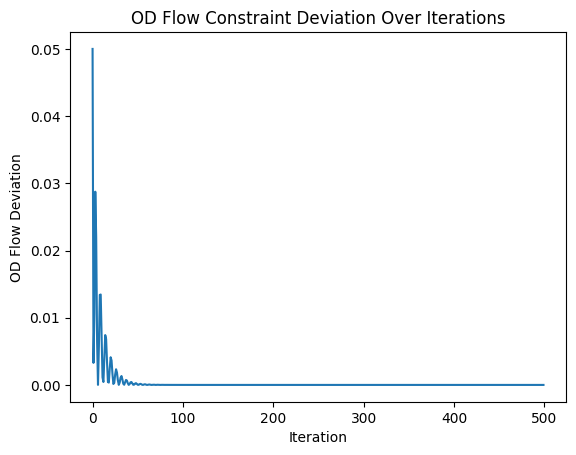

In [ ]:
import tensorflow as tf

def system_optimal_assignment_with_initialization(B_OD_P, A_PL, f_OD, t_0, capacity, alpha=0.15, beta=4.0, num_steps=500, lr=0.1, penalty_weight=1e6):
    """
    Solve the system optimal traffic assignment problem with improved initialization and OD flow constraint handling.

    Args:
    - B_OD_P: OD-to-path assignment matrix (Tensor of shape [num_OD, num_paths]).
    - A_PL: Path-to-link incidence matrix (Tensor of shape [num_paths, num_links]).
    - f_OD: OD demand vector (Tensor of shape [num_OD]).
    - t_0: Free-flow travel times on links (Tensor of shape [num_links]).
    - capacity: Link capacities (Tensor of shape [num_links]).
    - alpha: Parameter for volume-delay function (default: 0.15).
    - beta: Parameter for volume-delay function (default: 4.0).
    - num_steps: Number of optimization steps.
    - lr: Learning rate for the optimizer.
    - penalty_weight: Penalty weight for OD flow constraints (default: 1e6).

    Returns:
    - f_P: Optimized path flows (Tensor of shape [num_paths]).
    - f_L: Link flows (Tensor of shape [num_links]).
    - T_L: Link travel times (Tensor of shape [num_links]).
    - T_P: Path travel times (Tensor of shape [num_paths]).
    - deviations: List of OD flow constraint deviations over iterations.
    """
    # Initialize path flows based on OD demands (good initial solution)
    initial_f_P = tf.linalg.matvec(tf.transpose(B_OD_P), f_OD)

    # Create a trainable variable for path flows, initialized with the good initial solution
    f_P = tf.Variable(initial_f_P, trainable=True, dtype=tf.float32)

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # Deviation log
    deviations = []

    # Training loop
    for step in range(num_steps):
        with tf.GradientTape() as tape:
            # Compute link flows (f_L = A_PL^T * f_P)
            f_L = tf.linalg.matvec(tf.transpose(A_PL), f_P)

            # Compute link travel times (T_L = t_0 * (1 + alpha * (f_L / capacity)^beta))
            T_L = t_0 * (1 + alpha * (f_L / capacity) ** beta)

            # Compute path travel times (T_P = A_PL * T_L)
            T_P = tf.linalg.matvec(A_PL, T_L)

            # Total travel time objective (minimize sum(f_P * T_P))
            total_travel_time = tf.reduce_sum(f_P * T_P)

            # OD flow constraint penalty (||B_OD,P^T * f_OD - f_P||^2)
            od_constraint_violation = tf.reduce_sum(tf.square(tf.linalg.matvec(tf.transpose(B_OD_P), f_OD) - f_P))

            # Loss = total travel time + penalty for OD constraint violations
            loss = total_travel_time + penalty_weight * od_constraint_violation

        # Compute and apply gradients
        gradients = tape.gradient(loss, [f_P])
        optimizer.apply_gradients(zip(gradients, [f_P]))

        # Enforce non-negativity
        f_P.assign(tf.maximum(f_P, 0.0))

        # Track deviation for OD flow constraints
        deviation = tf.reduce_sum(tf.square(tf.linalg.matvec(tf.transpose(B_OD_P), f_OD) - f_P)).numpy()
        deviations.append(deviation)

        # Log progress every 100 steps
        if step % 100 == 0 or step == num_steps - 1:
            print(f"Step {step}, Loss: {loss.numpy():.2f}, Total Travel Time: {total_travel_time.numpy():.2f}")
            print(f"Deviation (OD Flow): {deviation:.4f}")

    # Final results
    f_L = tf.linalg.matvec(tf.transpose(A_PL), f_P)
    T_L = t_0 * (1 + alpha * (f_L / capacity) ** beta)
    T_P = tf.linalg.matvec(A_PL, T_L)

    return f_P.numpy(), f_L.numpy(), T_L.numpy(), T_P.numpy(), deviations


# Example Input Data
B_OD_P = tf.constant([
    [1, 0, 0, 0, 0],  # (1,3)
    [0, 1, 0, 0, 0],  # (1,4)
    [0, 0, 1, 0, 0],  # (2,3)
    [0, 0, 0, 0.3, 0.7]  # (2,4)
], dtype=tf.float32)

A_PL = tf.constant([
    [1, 1, 0],  # Path 1
    [1, 1, 0],  # Path 2
    [0, 1, 1],  # Path 3
    [0, 1, 1],  # Path 4
    [0, 0, 1]   # Path 5
], dtype=tf.float32)

f_OD = tf.constant([4000.0, 1000.0, 2000.0, 2000.0], dtype=tf.float32)  # OD volumes
t_0 = tf.constant([15.0, 18.0, 10.0], dtype=tf.float32)  # Free-flow travel times for links
capacity = tf.constant([5000.0, 8000.0, 3000.0], dtype=tf.float32)  # Link capacities

# Solve the system optimal problem with improved initialization
f_P, f_L, T_L, T_P, deviations = system_optimal_assignment_with_initialization(
    B_OD_P, A_PL, f_OD, t_0, capacity
)

# Print final results
print("\nOptimized Path Flows (f_P):", f_P)
print("Link Flows (f_L):", f_L)
print("Link Travel Times (T_L):", T_L)
print("Path Travel Times (T_P):", T_P)

# Plot deviation over iterations (requires matplotlib)
import matplotlib.pyplot as plt
plt.plot(deviations)
plt.xlabel('Iteration')
plt.ylabel('OD Flow Deviation')
plt.title('OD Flow Constraint Deviation Over Iterations')
plt.show()


Step 0, Loss: 298726.59, Total Travel Time: 298726.59
Deviation (OD Flow): 0.0500
Step 100, Loss: 298727.97, Total Travel Time: 298726.50
Deviation (OD Flow): 0.0000
Step 200, Loss: 298726.62, Total Travel Time: 298726.59
Deviation (OD Flow): 0.0000
Step 300, Loss: 298726.69, Total Travel Time: 298726.62
Deviation (OD Flow): 0.0000
Step 400, Loss: 298726.66, Total Travel Time: 298726.59
Deviation (OD Flow): 0.0000
Step 499, Loss: 298726.69, Total Travel Time: 298726.59
Deviation (OD Flow): 0.0000

Optimized Path Flows (f_P): [4000. 1000. 2000.  600. 1400.]
Link Flows (f_L): [5000. 7600. 4000.]
Link Travel Times (T_L): [17.25     20.199167 14.740742]
Path Travel Times (T_P): [37.449165 37.449165 34.93991  34.93991  14.740742]


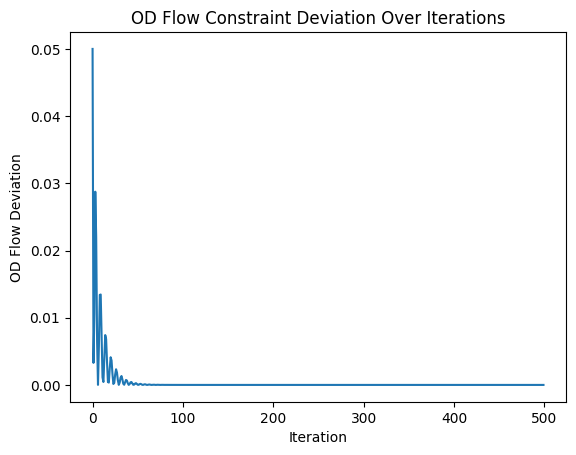

In [ ]:
import tensorflow as tf

def system_optimal_assignment_tensor_based(B_OD_P, A_PL, f_OD, t_0, capacity, alpha=0.15, beta=4.0, num_steps=500, lr=0.1, penalty_weight=1e6):
    """
    Solve the system optimal traffic assignment problem using tensor-based implementation.

    Args:
    - B_OD_P: OD-to-path assignment matrix (Tensor of shape [num_OD, num_paths]).
    - A_PL: Path-to-link incidence matrix (Tensor of shape [num_paths, num_links]).
    - f_OD: OD demand vector (Tensor of shape [num_OD]).
    - t_0: Free-flow travel times on links (Tensor of shape [num_links]).
    - capacity: Link capacities (Tensor of shape [num_links]).
    - alpha: Parameter for volume-delay function (default: 0.15).
    - beta: Parameter for volume-delay function (default: 4.0).
    - num_steps: Number of optimization steps.
    - lr: Learning rate for the optimizer.
    - penalty_weight: Penalty weight for OD flow constraints (default: 1e6).

    Returns:
    - f_P: Optimized path flows (Tensor of shape [num_paths]).
    - f_L: Link flows (Tensor of shape [num_links]).
    - T_L: Link travel times (Tensor of shape [num_links]).
    - T_P: Path travel times (Tensor of shape [num_paths]).
    - deviations: List of OD flow constraint deviations over iterations.
    """
    # Initialize path flows based on OD demands (good initial solution)
    initial_f_P = tf.linalg.matvec(tf.transpose(B_OD_P), f_OD)  # Compute initial path flows

    # Create a trainable variable for path flows, initialized with the good initial solution
    f_P = tf.Variable(initial_f_P, trainable=True, dtype=tf.float32)

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # Deviation log
    deviations = []

    # Training loop
    for step in range(num_steps):
        with tf.GradientTape() as tape:
            # Compute link flows (f_L = A_PL^T @ f_P)
            f_L = tf.matmul(tf.transpose(A_PL), tf.expand_dims(f_P, axis=1))  # Shape: [num_links, 1]
            f_L = tf.squeeze(f_L)  # Remove the singleton dimension for compatibility

            # Compute link travel times (T_L = t_0 * (1 + alpha * (f_L / capacity)^beta))
            T_L = t_0 * (1 + alpha * (f_L / capacity) ** beta)  # Element-wise operations

            # Compute path travel times (T_P = A_PL @ T_L)
            T_L_expanded = tf.expand_dims(T_L, axis=1)  # Shape: [num_links, 1] for matmul
            T_P = tf.matmul(A_PL, T_L_expanded)  # Shape: [num_paths, 1]
            T_P = tf.squeeze(T_P)  # Remove singleton dimension

            # Total travel time objective (minimize sum(f_P * T_P))
            total_travel_time = tf.reduce_sum(f_P * T_P)

            # OD flow constraint penalty (||B_OD,P^T * f_OD - f_P||^2)
            f_P_projected = tf.matmul(tf.transpose(B_OD_P), tf.expand_dims(f_OD, axis=1))  # Shape: [num_paths, 1]
            f_P_projected = tf.squeeze(f_P_projected)
            od_constraint_violation = tf.reduce_sum(tf.square(f_P_projected - f_P))

            # Loss = total travel time + penalty for OD constraint violations
            loss = total_travel_time + penalty_weight * od_constraint_violation

        # Compute and apply gradients
        gradients = tape.gradient(loss, [f_P])
        optimizer.apply_gradients(zip(gradients, [f_P]))

        # Enforce non-negativity
        f_P.assign(tf.maximum(f_P, 0.0))

        # Track deviation for OD flow constraints
        deviation = tf.reduce_sum(tf.square(tf.linalg.matvec(tf.transpose(B_OD_P), f_OD) - f_P)).numpy()
        deviations.append(deviation)

        # Log progress every 100 steps
        if step % 100 == 0 or step == num_steps - 1:
            print(f"Step {step}, Loss: {loss.numpy():.2f}, Total Travel Time: {total_travel_time.numpy():.2f}")
            print(f"Deviation (OD Flow): {deviation:.4f}")

    # Final results
    f_L = tf.matmul(tf.transpose(A_PL), tf.expand_dims(f_P, axis=1))
    T_L = t_0 * (1 + alpha * (tf.squeeze(f_L) / capacity) ** beta)
    T_P = tf.matmul(A_PL, tf.expand_dims(T_L, axis=1))

    return f_P.numpy(), tf.squeeze(f_L).numpy(), T_L.numpy(), tf.squeeze(T_P).numpy(), deviations


# Example Input Data
B_OD_P = tf.constant([
    [1, 0, 0, 0, 0],  # (1,3)
    [0, 1, 0, 0, 0],  # (1,4)
    [0, 0, 1, 0, 0],  # (2,3)
    [0, 0, 0, 0.3, 0.7]  # (2,4)
], dtype=tf.float32)

A_PL = tf.constant([
    [1, 1, 0],  # Path 1
    [1, 1, 0],  # Path 2
    [0, 1, 1],  # Path 3
    [0, 1, 1],  # Path 4
    [0, 0, 1]   # Path 5
], dtype=tf.float32)

f_OD = tf.constant([4000.0, 1000.0, 2000.0, 2000.0], dtype=tf.float32)  # OD volumes
t_0 = tf.constant([15.0, 18.0, 10.0], dtype=tf.float32)  # Free-flow travel times for links
capacity = tf.constant([5000.0, 8000.0, 3000.0], dtype=tf.float32)  # Link capacities

# Solve the system optimal problem with tensor-based implementation
f_P, f_L, T_L, T_P, deviations = system_optimal_assignment_tensor_based(
    B_OD_P, A_PL, f_OD, t_0, capacity
)

# Print final results
print("\nOptimized Path Flows (f_P):", f_P)
print("Link Flows (f_L):", f_L)
print("Link Travel Times (T_L):", T_L)
print("Path Travel Times (T_P):", T_P)

# Plot deviation over iterations (requires matplotlib)
import matplotlib.pyplot as plt
plt.plot(deviations)
plt.xlabel('Iteration')
plt.ylabel('OD Flow Deviation')
plt.title('OD Flow Constraint Deviation Over Iterations')
plt.show()


ODME

In [ ]:
def system_optimal_assignment_with_link_deviation(
    B_OD_P, A_PL, f_OD, t_0, capacity, link_observed, alpha=0.15, beta=4.0,
    num_steps=500, lr=0.1, penalty_weight_od=1e6, penalty_weight_link=1e6):
    initial_f_P = tf.linalg.matvec(tf.transpose(B_OD_P), f_OD)  # Initialize path flows
    f_P = tf.Variable(initial_f_P, trainable=True, dtype=tf.float32)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    deviations = []

    for step in range(num_steps):
        with tf.GradientTape() as tape:
            # Compute link flows
            f_L = tf.matmul(tf.transpose(A_PL), tf.expand_dims(f_P, axis=1))
            f_L = tf.squeeze(f_L)

            # Compute link travel times
            f_L_div_capacity = f_L / capacity  # Ensure compatibility
            T_L = t_0 * (1 + alpha * tf.pow(f_L_div_capacity, beta))

            # Compute path travel times
            T_L_expanded = tf.expand_dims(T_L, axis=1)
            T_P = tf.matmul(A_PL, T_L_expanded)
            T_P = tf.squeeze(T_P)

            # Total travel time
            total_travel_time = tf.reduce_sum(f_P * T_P)

            # OD flow constraint penalty
            f_P_projected = tf.matmul(tf.transpose(B_OD_P), tf.expand_dims(f_OD, axis=1))
            f_P_projected = tf.squeeze(f_P_projected)
            od_constraint_violation = tf.reduce_sum(tf.square(f_P_projected - f_P))

            # Link flow observation deviation penalty
            link_flow_deviation = tf.reduce_sum(tf.square(f_L - link_observed))

            # Loss
            loss = (
                total_travel_time
                + penalty_weight_od * od_constraint_violation
                + penalty_weight_link * link_flow_deviation
            )

        # Compute and apply gradients
        gradients = tape.gradient(loss, [f_P])
        optimizer.apply_gradients(zip(gradients, [f_P]))

        # Enforce non-negativity
        f_P.assign(tf.maximum(f_P, 0.0))

        # Track deviation
        deviation = tf.reduce_sum(tf.square(f_P_projected - f_P)).numpy()
        deviations.append(deviation)

        # Log progress
        if step % 100 == 0 or step == num_steps - 1:
            print(f"Step {step}, Loss: {loss.numpy():.2f}, Total Travel Time: {total_travel_time.numpy():.2f}")
            print(f"OD Flow Deviation: {deviation:.4f}, Link Flow Deviation: {link_flow_deviation.numpy():.4f}")

    # Final results
    f_L = tf.matmul(tf.transpose(A_PL), tf.expand_dims(f_P, axis=1))
    T_L = t_0 * (1 + alpha * (tf.squeeze(f_L) / capacity) ** beta)
    T_P = tf.matmul(A_PL, tf.expand_dims(T_L, axis=1))

    return f_P.numpy(), tf.squeeze(f_L).numpy(), T_L.numpy(), tf.squeeze(T_P).numpy(), deviations



In [ ]:
import tensorflow as tf

# Input Matrices for Braess Paradox Network
A_PL = tf.constant([
    [1, 0, 1, 0, 0],  # Path 1: Start → A → End
    [0, 1, 0, 1, 0],  # Path 2: Start → B → End
    [1, 0, 0, 1, 1]   # Path 3: Start → A → B → End
], dtype=tf.float32)

B_OD_P = tf.constant([
    [1, 1, 1]  # All paths serve the single OD pair (Start → End)
], dtype=tf.float32)

# Fixed OD Flow (Demand) for the single OD Pair
f_OD = tf.constant([4000.0], dtype=tf.float32)  # Start → End

# Free-flow Travel Times for Links (a, b, c, d, e)
T_L_0 = tf.constant([0.0, 45.0, 0.0, 45.0, 0.0], dtype=tf.float32)

# Link Capacities for Links (a, b, c, d, e)
C_L = tf.constant([100.0, 1e9, 100.0, 1e9, 1e9], dtype=tf.float32)

# BPR Parameters
alpha = 1.0  # Linear travel time for simplicity
beta = 1.0

# Initialize Path Flows (Decision Variable)
f_P = tf.Variable(tf.zeros([3], dtype=tf.float32))  # Path flows for paths 1, 2, 3

# Seed Initialization for Path Flows
def initialize_path_flows():
    # Distribute OD flow equally across paths
    path_counts = tf.reduce_sum(B_OD_P, axis=1)  # Count of paths for each OD pair
    path_flows = tf.matmul(tf.transpose(B_OD_P), tf.expand_dims(f_OD / path_counts, axis=1))[:, 0]
    f_P.assign(path_flows)

# Call the initialization function before optimization
initialize_path_flows()

# Objective Function
def objective_function():
    # Step 1: Compute Link Flows
    f_L = tf.matmul(tf.transpose(A_PL), tf.expand_dims(f_P, axis=1))[:, 0]  # Transposed A_PL

    # Step 2: Compute Link Travel Times (BPR Function)
    T_L = T_L_0 + alpha * (f_L / C_L) ** beta

    # Step 3: Compute Path Travel Times
    T_P = tf.matmul(A_PL, tf.expand_dims(T_L, axis=1))[:, 0]  # Path Travel Times from Link Travel Times

    # Step 4: Compute OD Travel Times
    T_OD = tf.matmul(B_OD_P, tf.expand_dims(T_P, axis=1))[:, 0]  # OD Travel Times from Path Travel Times

    # Total Travel Time
    total_travel_time = tf.reduce_sum(f_OD * T_OD)  # Use fixed OD flows

    return total_travel_time

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

# Constraint Function to Enforce Fixed OD Flow
def enforce_fixed_od_flow():
    # Compute OD Flows from Path Flows
    current_f_OD = tf.matmul(B_OD_P, tf.expand_dims(f_P, axis=1))[:, 0]
    # Enforce f_OD == fixed f_OD
    correction = current_f_OD - f_OD
    f_P.assign_sub(tf.matmul(tf.transpose(B_OD_P), tf.expand_dims(correction, axis=1))[:, 0])

# Training Loop
for step in range(500):
    with tf.GradientTape() as tape:
        loss = objective_function()
    gradients = tape.gradient(loss, [f_P])
    optimizer.apply_gradients(zip(gradients, [f_P]))

    # Enforce Non-Negativity
    f_P.assign(tf.maximum(f_P, 0.0))

    # Enforce Fixed OD Flow Constraint
    enforce_fixed_od_flow()

    # Logging every 100 steps
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss.numpy()}")
        print(f"Path Flows: {f_P.numpy()}")
        print()

# Final Results
f_L = tf.matmul(tf.transpose(A_PL), tf.expand_dims(f_P, axis=1))[:, 0]
T_L = T_L_0 + alpha * (f_L / C_L) ** beta
T_P = tf.matmul(A_PL, tf.expand_dims(T_L, axis=1))[:, 0]
T_OD = tf.matmul(B_OD_P, tf.expand_dims(T_P, axis=1))[:, 0]

print("Final Path Flows:", f_P.numpy())
print("Final Link Flows:", f_L.numpy())
print("Final OD Travel Times:", T_OD.numpy())


Step 0, Loss: 806666.6875
Path Flows: [1333.5122 1333.5331 1333.5122]

Step 100, Loss: -259960.75
Path Flows: [4000. 4000. 4000.]

Step 200, Loss: -259960.328125
Path Flows: [4000. 4000. 4000.]

Step 300, Loss: -259960.328125
Path Flows: [4000. 4000. 4000.]

Step 400, Loss: -259960.328125
Path Flows: [4000. 4000. 4000.]

Final Path Flows: [-3999.8013 -3999.7998 -3999.8013]
Final Link Flows: [-7999.6025 -3999.7998 -3999.8013 -7999.601  -3999.8013]
Final OD Travel Times: [-64.99008]


In [ ]:
from google.colab import files
import pandas as pd
import io

# Upload the files
uploaded = files.upload()

# Access the files
node_file = 'node.csv'  # Replace with your file name
link_file = 'link.csv'
route_assignment_file = 'route_assignment.csv'

# Load the data into pandas DataFrames
node_df = pd.read_csv(io.BytesIO(uploaded[node_file]))
link_df = pd.read_csv(io.BytesIO(uploaded[link_file]))
route_assignment_df = pd.read_csv(io.BytesIO(uploaded[route_assignment_file]))

# Display the content of the files to verify
print("Node File:")
print(node_df.head())
print("\nLink File:")
print(link_df.head())
print("\nRoute Assignment File:")
print(route_assignment_df.head())

Saving link.csv to link.csv
Saving node.csv to node.csv
Saving route_assignment.csv to route_assignment.csv
Node File:
   name  node_id  zone_id    x_coord    y_coord  district_id
0   NaN        1        1 -96.770420  43.612828          1.0
1   NaN        2        2 -96.711251  43.605813          2.0
2   NaN        3        3 -96.774303  43.572962          NaN
3   NaN        4        4 -96.747168  43.563654          NaN
4   NaN        5        5 -96.731569  43.564034          NaN

Link File:
   name  link_id  from_node_id  to_node_id  dir_flag  length  lanes  \
0   NaN        1             1           2         1       6      1   
1   NaN        2             1           3         1       4      1   
2   NaN        3             2           1         1       6      1   
3   NaN        4             2           6         1       5      1   
4   NaN        5             3           1         1       4      1   

       capacity  free_speed  link_type  VDF_alpha  VDF_beta  ref_volume  \
0

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np

def process_network_data(node_file, link_file, route_assignment_file):
    # Load the input files
    node_df = pd.read_csv(node_file)
    link_df = pd.read_csv(link_file)
    route_assignment_df = pd.read_csv(route_assignment_file)

    # Create Path-to-Link Matrix (A_PL)
    num_paths = len(route_assignment_df)
    num_links = len(link_df)
    A_PL = np.zeros((num_paths, num_links), dtype=np.float32)
    for i, row in route_assignment_df.iterrows():
        link_ids = [int(link_id) for link_id in str(row['link_ids']).split(';') if link_id.strip()]
        for link_id in link_ids:
            A_PL[i, link_id - 1] = 1  # Use 1-based indexing for link_id

    # Create OD-to-Path Matrix (B_OD_P)
    od_pairs = route_assignment_df[['origin', 'destination']].drop_duplicates().values
    num_od_pairs = len(od_pairs)
    B_OD_P = np.zeros((num_od_pairs, num_paths), dtype=np.float32)
    for i, (origin, destination) in enumerate(od_pairs):
        matching_paths = route_assignment_df[
            (route_assignment_df['origin'] == origin) & (route_assignment_df['destination'] == destination)
        ].index
        for path_id in matching_paths:
            B_OD_P[i, path_id] = 1

    # Extract OD demands
    od_demands = route_assignment_df.groupby(['origin', 'destination'])['total_travel_time'].sum().values

    # Extract Link Data: Capacities and Free-Flow Times
    C_L = link_df['capacity'].values.astype(np.float32)  # Link capacities
    T_L_0 = link_df['free_speed'].values.astype(np.float32)  # Free-flow travel times

    # Convert matrices to TensorFlow tensors
    A_PL_tensor = tf.constant(A_PL, dtype=tf.float32)
    B_OD_P_tensor = tf.constant(B_OD_P, dtype=tf.float32)
    od_demands_tensor = tf.constant(od_demands, dtype=tf.float32)
    C_L_tensor = tf.constant(C_L, dtype=tf.float32)
    T_L_0_tensor = tf.constant(T_L_0, dtype=tf.float32)

    return A_PL_tensor, B_OD_P_tensor, od_demands_tensor, C_L_tensor, T_L_0_tensor

# Define the files (use your uploaded files here)
node_file = "node.csv"
link_file = "link.csv"
route_assignment_file = "route_assignment.csv"

# Process the network data
A_PL, B_OD_P, f_OD, C_L, T_L_0 = process_network_data(node_file, link_file, route_assignment_file)

# Display the tensors to verify
print("Path-to-Link Matrix (A_PL):", A_PL.numpy())
print("OD-to-Path Matrix (B_OD_P):", B_OD_P.numpy())
print("OD Demands (f_OD):", f_OD.numpy())
print("Link Capacities (C_L):", C_L.numpy())
print("Free-Flow Travel Times (T_L_0):", T_L_0.numpy())


Path-to-Link Matrix (A_PL): [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
OD-to-Path Matrix (B_OD_P): [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
OD Demands (f_OD): [  6.00088   4.00902   8.31404  10.6568   12.5847   32.8938   27.2214
  20.5666   26.2893   15.855     8.03411  11.062    29.6049   81.8996
  75.7798   89.8352   34.9552   90.5522   39.2259   39.5231   88.1571
  32.0872   28.3665    6.00091  10.0099   14.315    33.3123    6.58378
  26.8929   21.2205   53.132    64.5774   21.8559   14.035    17.0629
  35.6058   92.2424   63.7781   82.0703   42.6312   33.225    41.1584
   4.00884  10.0097    4.30502   6.64774  33.0233  111.1255   94.108
  16.5576   22.2803   11.846     4.02509   7.05297  25.5959   73.8815
 209.65     39.0329   80.1391   28.0782    8.31758  1

In [ ]:
# BPR Function Parameters
alpha = 0.15
beta = 4.0

# Initialize Path Flows (f_P) evenly across paths
num_paths = A_PL.shape[0]
f_P = tf.Variable(tf.zeros(num_paths, dtype=tf.float32))

# Initialize Path Flows Based on OD Demands
def initialize_path_flows():
    path_counts = tf.reduce_sum(B_OD_P, axis=1)  # Count of paths for each OD pair
    initial_flows = tf.matmul(tf.transpose(B_OD_P), tf.expand_dims(f_OD / path_counts, axis=1))[:, 0]
    f_P.assign(initial_flows)

initialize_path_flows()

# Objective Function
def objective_function():
    # Step 1: Compute Link Flows (f_L)
    f_L = tf.matmul(tf.transpose(A_PL), tf.expand_dims(f_P, axis=1))[:, 0]

    # Step 2: Compute Link Travel Times (T_L)
    T_L = T_L_0 + alpha * (f_L / C_L) ** beta

    # Step 3: Compute Path Travel Times (T_P)
    T_P = tf.matmul(A_PL, tf.expand_dims(T_L, axis=1))[:, 0]

    # Step 4: Compute OD Travel Times (T_OD)
    T_OD = tf.matmul(B_OD_P, tf.expand_dims(T_P, axis=1))[:, 0]

    # Total Travel Time
    total_travel_time = tf.reduce_sum(f_OD * T_OD)
    return total_travel_time

# Constraint Enforcement for OD Flows
def enforce_od_flow_constraints():
    current_f_OD = tf.matmul(B_OD_P, tf.expand_dims(f_P, axis=1))[:, 0]
    correction = current_f_OD - f_OD
    f_P.assign_sub(tf.matmul(tf.transpose(B_OD_P), tf.expand_dims(correction, axis=1))[:, 0])

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

# Training Loop
for step in range(500):
    with tf.GradientTape() as tape:
        loss = objective_function()

    # Compute and apply gradients
    gradients = tape.gradient(loss, [f_P])
    optimizer.apply_gradients(zip(gradients, [f_P]))

    # Enforce Non-Negativity
    f_P.assign(tf.maximum(f_P, 0.0))

    # Enforce OD Flow Constraints
    enforce_od_flow_constraints()

    # Logging every 100 steps
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss.numpy():.2f}")

# Final Results
f_L = tf.matmul(tf.transpose(A_PL), tf.expand_dims(f_P, axis=1))[:, 0]
T_L = T_L_0 + alpha * (f_L / C_L) ** beta
T_P = tf.matmul(A_PL, tf.expand_dims(T_L, axis=1))[:, 0]
T_OD = tf.matmul(B_OD_P, tf.expand_dims(T_P, axis=1))[:, 0]

print("\nFinal Path Flows (f_P):", f_P.numpy())
print("Final Link Flows (f_L):", f_L.numpy())
print("Final Link Travel Times (T_L):", T_L.numpy())
print("Final Path Travel Times (T_P):", T_P.numpy())
print("Final OD Travel Times (T_OD):", T_OD.numpy())


Step 0, Loss: 12097838.00
Step 100, Loss: 12105514.00
Step 200, Loss: 12105396.00
Step 300, Loss: 12105290.00
Step 400, Loss: 12105190.00

Final Path Flows (f_P): [ 6.00087976e+00  4.00901985e+00  8.31404018e+00  1.06568003e+01
  1.25846996e+01  3.28937988e+01  2.72213993e+01  2.05666008e+01
  2.62893009e+01  1.58549995e+01  8.03411007e+00  1.10620003e+01
  2.96049004e+01  4.08473396e+01  4.64148293e+01  4.37522545e+01
  3.72257004e+01  4.12895813e+01  5.37752876e+01  3.49552002e+01
  4.58607750e+01  5.00503960e+01  3.92258987e+01  3.95231018e+01
  4.23326836e+01  5.06892128e+01  3.20872002e+01  2.83665009e+01
  6.00090981e+00  1.00099001e+01  1.43149996e+01  2.31458111e+01
  1.51736221e+01  6.58377981e+00  2.68929005e+01  2.12205009e+01
  3.71182289e+01  2.11197586e+01  4.32000198e+01  2.64860630e+01
  2.18558998e+01  1.40349998e+01  1.70629005e+01  3.56058006e+01
  5.74321823e+01  3.99251366e+01  3.77513962e+01  3.12248631e+01
  4.68979607e+01  4.03705978e+01  4.26311989e+01  3.32249

Offline code in Spyder

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np

# Function to process network data
def process_network_data(node_file, link_file, route_assignment_file):
    # Load the input files
    node_df = pd.read_csv(node_file)
    link_df = pd.read_csv(link_file)
    route_assignment_df = pd.read_csv(route_assignment_file)

    # Create Path-to-Link Matrix (A_PL)
    num_paths = len(route_assignment_df)
    num_links = len(link_df)
    A_PL = np.zeros((num_paths, num_links), dtype=np.float32)
    for i, row in route_assignment_df.iterrows():
        link_ids = [int(link_id) for link_id in str(row['link_ids']).split(';') if link_id.strip()]
        for link_id in link_ids:
            A_PL[i, link_id - 1] = 1  # Use 1-based indexing for link_id

    # Create OD-to-Path Matrix (B_OD_P)
    od_pairs = route_assignment_df[['origin', 'destination']].drop_duplicates().values
    num_od_pairs = len(od_pairs)
    B_OD_P = np.zeros((num_od_pairs, num_paths), dtype=np.float32)
    for i, (origin, destination) in enumerate(od_pairs):
        matching_paths = route_assignment_df[
            (route_assignment_df['origin'] == origin) & (route_assignment_df['destination'] == destination)
        ].index
        for path_id in matching_paths:
            B_OD_P[i, path_id] = 1

    # Extract OD demands
    od_demands = route_assignment_df.groupby(['origin', 'destination'])['total_travel_time'].sum().values

    # Extract Link Data: Capacities and Free-Flow Times
    C_L = link_df['capacity'].values.astype(np.float32)  # Link capacities
    T_L_0 = link_df['free_speed'].values.astype(np.float32)  # Free-flow travel times

    # Convert matrices to TensorFlow tensors
    A_PL_tensor = tf.constant(A_PL, dtype=tf.float32)
    B_OD_P_tensor = tf.constant(B_OD_P, dtype=tf.float32)
    od_demands_tensor = tf.constant(od_demands, dtype=tf.float32)
    C_L_tensor = tf.constant(C_L, dtype=tf.float32)
    T_L_0_tensor = tf.constant(T_L_0, dtype=tf.float32)

    return A_PL_tensor, B_OD_P_tensor, od_demands_tensor, C_L_tensor, T_L_0_tensor

# Traffic Assignment Function
def traffic_assignment(A_PL, B_OD_P, f_OD, C_L, T_L_0, alpha=0.15, beta=4.0, num_steps=500, lr=0.1):
    # Initialize Path Flows (f_P) evenly across paths
    num_paths = A_PL.shape[0]
    f_P = tf.Variable(tf.zeros(num_paths, dtype=tf.float32))

    def initialize_path_flows():
        path_counts = tf.reduce_sum(B_OD_P, axis=1)  # Count of paths for each OD pair
        initial_flows = tf.matmul(tf.transpose(B_OD_P), tf.expand_dims(f_OD / path_counts, axis=1))[:, 0]
        f_P.assign(initial_flows)

    initialize_path_flows()

    # Objective Function
    def objective_function():
        # Compute Link Flows (f_L)
        f_L = tf.matmul(tf.transpose(A_PL), tf.expand_dims(f_P, axis=1))[:, 0]

        # Compute Link Travel Times (T_L)
        T_L = T_L_0 + alpha * (f_L / C_L) ** beta

        # Compute Path Travel Times (T_P)
        T_P = tf.matmul(A_PL, tf.expand_dims(T_L, axis=1))[:, 0]

        # Compute OD Travel Times (T_OD)
        T_OD = tf.matmul(B_OD_P, tf.expand_dims(T_P, axis=1))[:, 0]

        # Total Travel Time
        total_travel_time = tf.reduce_sum(f_OD * T_OD)
        return total_travel_time

    # Constraint Enforcement for OD Flows
    def enforce_od_flow_constraints():
        current_f_OD = tf.matmul(B_OD_P, tf.expand_dims(f_P, axis=1))[:, 0]
        correction = current_f_OD - f_OD
        f_P.assign_sub(tf.matmul(tf.transpose(B_OD_P), tf.expand_dims(correction, axis=1))[:, 0])

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # Training Loop
    for step in range(num_steps):
        with tf.GradientTape() as tape:
            loss = objective_function()

        # Compute and apply gradients
        gradients = tape.gradient(loss, [f_P])
        optimizer.apply_gradients(zip(gradients, [f_P]))

        # Enforce Non-Negativity
        f_P.assign(tf.maximum(f_P, 0.0))

        # Enforce OD Flow Constraints
        enforce_od_flow_constraints()

        # Logging every 100 steps
        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss.numpy():.2f}")

    # Final Results
    f_L = tf.matmul(tf.transpose(A_PL), tf.expand_dims(f_P, axis=1))[:, 0]
    T_L = T_L_0 + alpha * (f_L / C_L) ** beta
    T_P = tf.matmul(A_PL, tf.expand_dims(T_L, axis=1))[:, 0]
    T_OD = tf.matmul(B_OD_P, tf.expand_dims(T_P, axis=1))[:, 0]

    return f_P.numpy(), f_L.numpy(), T_L.numpy(), T_P.numpy(), T_OD.numpy()

# Load the files (replace paths with your local file paths)
node_file = "node.csv"
link_file = "link.csv"
route_assignment_file = "route_assignment.csv"

# Process the network data
A_PL, B_OD_P, f_OD, C_L, T_L_0 = process_network_data(node_file, link_file, route_assignment_file)

# Run the traffic assignment
f_P, f_L, T_L, T_P, T_OD = traffic_assignment(A_PL, B_OD_P, f_OD, C_L, T_L_0)

# Print the final results
print("\nFinal Path Flows (f_P):", f_P)
print("Final Link Flows (f_L):", f_L)
print("Final Link Travel Times (T_L):", T_L)
print("Final Path Travel Times (T_P):", T_P)
print("Final OD Travel Times (T_OD):", T_OD)


In [ ]:
import tensorflow as tf

# Input Matrices for Braess Paradox Network
A_PL = tf.constant([
    [1, 0, 1, 0, 0],  # Path 1: Start → A → End
    [0, 1, 0, 1, 0],  # Path 2: Start → B → End
    [1, 0, 0, 1, 1]   # Path 3: Start → A → B → End
], dtype=tf.float32)

B_OD_P = tf.constant([
    [1, 1, 1]  # All paths serve the single OD pair (Start → End)
], dtype=tf.float32)

# Fixed OD Flow (Demand)
f_OD = tf.constant([4000.0], dtype=tf.float32)

# Link Free-flow Travel Times and Capacities
T_L_0 = tf.constant([0.0, 0.0, 0.0, 0.0, 10.0], dtype=tf.float32)  # Free-flow times (last link e is fixed)
C_L = tf.constant([100.0, 100.0, 100.0, 100.0, 1e9], dtype=tf.float32)  # Capacities (link e has infinite capacity)

# BPR Parameters
alpha = 1.0  # Linear cost for simplicity
beta = 1.0

# Initialize Path Flows (Decision Variable)
f_P = tf.Variable(tf.zeros([3], dtype=tf.float32))  # Path flows for paths 1, 2, 3

# Seed Initialization for Path Flows
def initialize_path_flows():
    """
    Initialize the path flows to split the OD flow (f_OD) equally across
    the first two paths. Initially, set the third path flow to 0.
    """
    initial_flows = [2000.0, 1000.0, 1000.0]  # Split OD flow: 2000 each for paths 1 and 2, 0 for path 3
    f_P.assign(tf.constant(initial_flows, dtype=tf.float32))

# Call the initialization function before optimization
initialize_path_flows()

# Optimizer (Created after initialization of f_P)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)


# Objective Function for UE (Beckmann Transformation)
def objective_function_UE():
    # Step 1: Compute Link Flows
    f_L = tf.matmul(tf.transpose(A_PL), tf.expand_dims(f_P, axis=1))[:, 0]

    # Step 2: Compute Link Travel Times (BPR Function)
    T_L = T_L_0 + alpha * (f_L / C_L) ** beta

    # Step 3: Compute Link Travel Time Integral for Objective
    link_travel_cost = tf.reduce_sum(T_L_0 * f_L + (alpha / (beta + 1)) * (f_L / C_L) ** (beta + 1) * C_L)

    # Non-Negativity Penalty
    non_negativity_penalty = tf.reduce_sum(tf.nn.relu(-f_P) ** 2)
    return link_travel_cost + 1e6 * non_negativity_penalty

# Objective Function
def objective_function_SO():
    # Step 1: Compute Link Flows
    f_L = tf.matmul(tf.transpose(A_PL), tf.expand_dims(f_P, axis=1))[:, 0]

    # Step 2: Compute Link Travel Times (BPR Function)
    T_L = T_L_0 + alpha * (f_L / C_L) ** beta

    # Step 3: Compute Path Travel Times
    T_P = tf.matmul(A_PL, tf.expand_dims(T_L, axis=1))[:, 0]

    # Step 4: Compute OD Travel Times
    T_OD = tf.matmul(B_OD_P, tf.expand_dims(T_P, axis=1))[:, 0]

    # Total Travel Time
    total_travel_time = tf.reduce_sum(f_OD * T_OD)

    # Non-Negativity Penalty
    non_negativity_penalty = tf.reduce_sum(tf.nn.relu(-f_P) ** 2)

    return total_travel_time + 1e6 * non_negativity_penalty

# Constraint Function to Enforce Fixed OD Flow
def enforce_fixed_od_flow():
    # Compute OD Flows from Path Flows
    current_f_OD = tf.matmul(B_OD_P, tf.expand_dims(f_P, axis=1))[:, 0]

    # Enforce f_OD == fixed f_OD with scaled correction
    correction = current_f_OD - f_OD
    f_P.assign_sub(0.1 * tf.matmul(tf.transpose(B_OD_P), tf.expand_dims(correction, axis=1))[:, 0])

# Enhanced Logging Function
def log_progress(step, loss, f_P, f_L, T_L, T_P, T_OD):
    """
    Log the progress of the optimization in a readable format.
    """
    print(f"Step {step}, Loss: {loss:.2f}")
    print("Path Flows:")
    for i, flow in enumerate(f_P.numpy()):
        print(f"  Path {i + 1}: {flow:.2f}")
    print("Link Flows:")
    for i, flow in enumerate(f_L.numpy()):
        print(f"  Link {i + 1}: {flow:.2f}")
    print("OD Travel Times:")
    for i, time in enumerate(T_OD.numpy()):
        print(f"  OD Pair {i + 1}: {time:.2f}")
    print("-" * 50)

# Training Loop
for step in range(5000):
    with tf.GradientTape() as tape:
        loss = objective_function_UE()
    gradients = tape.gradient(loss, [f_P])
    optimizer.apply_gradients(zip(gradients, [f_P]))

    # Enforce Non-Negativity within Training Loop
    f_P.assign(tf.maximum(f_P, 0.0))

    # Enforce Fixed OD Flow Constraint
    enforce_fixed_od_flow()

    # Forward propagation for intermediate results
    f_L = tf.matmul(tf.transpose(A_PL), tf.expand_dims(f_P, axis=1))[:, 0]
    T_L = T_L_0 + alpha * (f_L / C_L) ** beta
    T_P = tf.matmul(A_PL, tf.expand_dims(T_L, axis=1))[:, 0]
    T_OD = tf.matmul(B_OD_P, tf.expand_dims(T_P, axis=1))[:, 0]

    # Logging every 100 steps
    if step % 100 == 0:
        log_progress(step, loss.numpy(), f_P, f_L, T_L, T_P, T_OD)

# Final Results
f_L = tf.matmul(tf.transpose(A_PL), tf.expand_dims(f_P, axis=1))[:, 0]
T_L = T_L_0 + alpha * (f_L / C_L) ** beta
T_P = tf.matmul(A_PL, tf.expand_dims(T_L, axis=1))[:, 0]
T_OD = tf.matmul(B_OD_P, tf.expand_dims(T_P, axis=1))[:, 0]

print("Final Path Flows:", f_P.numpy())
print("Final Link Flows:", f_L.numpy())
print("Final OD Travel Times:", T_OD.numpy())




Step 0, Loss: 100000.00
Path Flows:
  Path 1: 1999.93
  Path 2: 999.93
  Path 3: 999.93
Link Flows:
  Link 1: 2999.86
  Link 2: 999.93
  Link 3: 1999.93
  Link 4: 1999.86
  Link 5: 999.93
OD Travel Times:
  OD Pair 1: 139.99
--------------------------------------------------
Step 100, Loss: 99967.36
Path Flows:
  Path 1: 1999.77
  Path 2: 999.77
  Path 3: 999.77
Link Flows:
  Link 1: 2999.53
  Link 2: 999.77
  Link 3: 1999.77
  Link 4: 1999.53
  Link 5: 999.77
OD Travel Times:
  OD Pair 1: 139.98
--------------------------------------------------
Step 200, Loss: 99967.36
Path Flows:
  Path 1: 1999.77
  Path 2: 999.77
  Path 3: 999.77
Link Flows:
  Link 1: 2999.53
  Link 2: 999.77
  Link 3: 1999.77
  Link 4: 1999.53
  Link 5: 999.77
OD Travel Times:
  OD Pair 1: 139.98
--------------------------------------------------
Step 300, Loss: 99967.36
Path Flows:
  Path 1: 1999.77
  Path 2: 999.77
  Path 3: 999.77
Link Flows:
  Link 1: 2999.53
  Link 2: 999.77
  Link 3: 1999.77
  Link 4: 1999.5

Network: A → B → D, A → C → D, B → C
Edge Costs: {("A", "B"): 1, ("A", "C"): 2, ("B", "C"): 1, ("B", "D"): 2, ("C", "D"): 1}


In [ ]:
import tensorflow as tf
import collections

def find_path(network, source, sink):
    """
    Find a path from the source to the sink in the network using BFS.

    Args:
    - network: Adjacency list representation of the graph (dict {node: [neighbors]}).
    - source: Source node (supply node).
    - sink: Sink node (demand node).

    Returns:
    - path: A list of edges representing a path from source to sink, or an empty list if no path is found.
    """
    queue = collections.deque([source])
    visited = {source: None}

    # Perform BFS to find a path from source to sink
    while queue:
        current = queue.popleft()
        if current == sink:
            break
        for neighbor in network.get(current, []):
            if neighbor not in visited:
                visited[neighbor] = current
                queue.append(neighbor)

    # Reconstruct the path from source to sink
    if sink not in visited:
        return []  # No path found

    path = []
    node = sink
    while node != source:
        prev_node = visited[node]
        path.append((prev_node, node))
        node = prev_node
    path.reverse()  # Reverse to get the path from source to sink
    return path

def initialize_feasible_flow(network, source, sink):
    """
    Generate an initial feasible flow along a path from source to sink.

    Args:
    - network: Adjacency list representation of the graph (dict {node: [neighbors]}).
    - source: Source node (supply node).
    - sink: Sink node (demand node).

    Returns:
    - initial_flow: Dictionary with initial feasible flow for each edge {(i, j): flow_value}.
    """
    # Initialize flow for each edge to zero
    initial_flow = {(i, j): 0.0 for i in network for j in network[i]}

    # Find a path from source to sink
    path = find_path(network, source, sink)

    # Set an initial flow value for edges along the path
    for edge in path:
        initial_flow[edge] = 2.0  # Assign a larger initial feasible flow value

    return initial_flow

def shortest_path_one_directional(network, source, sink, edge_costs, num_steps=500, lr=0.005, initial_penalty=0.1, penalty_growth=1.02, max_penalty=1e3):
    """
    Solve the shortest path problem with flow balance constraints using TensorFlow.

    Args:
    - network: Adjacency list representation of the graph (dict {node: [neighbors]}).
    - source: Source node (supply node).
    - sink: Sink node (demand node).
    - edge_costs: Dictionary with edge costs {(i, j): cost}.
    - num_steps: Number of optimization steps.
    - lr: Learning rate for the optimizer.
    - initial_penalty: Initial penalty weight for the flow balance constraint.
    - penalty_growth: Growth factor for penalty weight.
    - max_penalty: Maximum allowable penalty weight.

    Returns:
    - x: Optimized flow on edges (Tensor with same size as edge_costs).
    """
    # Extract all edges from the network
    edges = [(i, j) for i in network for j in network[i]]

    # Generate an initial feasible flow solution
    initial_flow_dict = initialize_feasible_flow(network, source, sink)
    initial_flow = [initial_flow_dict[edge] for edge in edges]

    # Initialize flow variables x(i, j) with the initial feasible values
    x = tf.Variable(initial_flow, dtype=tf.float32, trainable=True)

    # Edge-to-node incidence matrix
    num_nodes = len(network)
    num_edges = len(edges)
    node_index = {node: idx for idx, node in enumerate(network.keys())}

    # Build edge-to-node incidence matrix
    edge_to_node_data = []
    for edge_idx, (i, j) in enumerate(edges):
        edge_to_node_data.append((node_index[i], edge_idx, 1.0))  # Outflow
        edge_to_node_data.append((node_index[j], edge_idx, -1.0))  # Inflow

    # Sort indices for SparseTensor
    edge_to_node_data.sort(key=lambda x: (x[0], x[1]))
    indices = [(i, j) for i, j, _ in edge_to_node_data]
    values = [v for _, _, v in edge_to_node_data]

    # Convert to dense matrix
    edge_to_node = tf.sparse.to_dense(
        tf.sparse.reorder(
            tf.sparse.SparseTensor(indices=indices, values=values, dense_shape=(num_nodes, num_edges))
        )
    )

    # Cost vector for edges
    cost_vector = tf.constant([edge_costs[edge] for edge in edges], dtype=tf.float32)

    # Optimizer
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)

    # Initial penalty weight
    penalty_weight = initial_penalty

    # Optimization loop
    for step in range(num_steps):
        with tf.GradientTape() as tape:
            # Compute flow imbalance at each node
            flow_balance = tf.matmul(edge_to_node, tf.expand_dims(x, axis=1))
            flow_balance = tf.squeeze(flow_balance)

            # Adjust flow balance for source and sink nodes
            flow_balance = tf.tensor_scatter_nd_add(
                flow_balance,
                [[node_index[source]], [node_index[sink]]],
                [1.0, -1.0]  # Source injects +1, sink extracts -1
            )

            # Objective: Minimize total cost
            total_cost = tf.reduce_sum(x * cost_vector)

            # Constraint: Penalize flow imbalance
            flow_balance_penalty = tf.reduce_sum(tf.square(flow_balance))

            # Loss = Total cost + flow balance penalty
            loss = total_cost + penalty_weight * flow_balance_penalty

        # Compute and apply gradients
        gradients = tape.gradient(loss, [x])
        optimizer.apply_gradients(zip(gradients, [x]))

        # Enforce non-negativity
        x.assign(tf.maximum(x, 0.0))

        # Gradually increase penalty weight, with a cap
        penalty_weight = min(penalty_weight * penalty_growth, max_penalty)

        # Log progress
        if step % 100 == 0 or step == num_steps - 1:
            print(f"Step {step}, Loss: {loss.numpy():.2f}, Total Cost: {total_cost.numpy():.2f}, Flow Penalty: {flow_balance_penalty.numpy():.4f}")

    return x.numpy()

# Example Network Input
network = {
    "A": ["B", "C"],
    "B": ["C", "D"],
    "C": ["D"],
    "D": []
}

edge_costs = {
    ("A", "B"): 1.0,
    ("A", "C"): 2.0,
    ("B", "C"): 1.0,
    ("B", "D"): 2.0,
    ("C", "D"): 1.0
}

source = "A"
sink = "D"

# Solve shortest path problem
optimal_flow = shortest_path_one_directional(network, source, sink, edge_costs)

# Print results
print("\nOptimal Flow on Edges:")
for edge, flow in zip(edge_costs.keys(), optimal_flow):
    print(f"Edge {edge}: Flow = {flow:.2f}")




Step 0, Loss: 7.80, Total Cost: 6.00, Flow Penalty: 18.0000
Step 100, Loss: 12.77, Total Cost: 4.27, Flow Penalty: 11.7277
Step 200, Loss: 39.01, Total Cost: 2.60, Flow Penalty: 6.9375
Step 300, Loss: 128.93, Total Cost: 0.90, Flow Penalty: 3.3672
Step 400, Loss: 550.93, Total Cost: 0.00, Flow Penalty: 2.0000
Step 499, Loss: 2000.00, Total Cost: 0.00, Flow Penalty: 2.0000

Optimal Flow on Edges:
Edge ('A', 'B'): Flow = 0.00
Edge ('A', 'C'): Flow = 0.00
Edge ('B', 'C'): Flow = 0.00
Edge ('B', 'D'): Flow = 0.00
Edge ('C', 'D'): Flow = 0.00


In [ ]:
import torch

# Define the network data
nodes = 4  # A, B, C, D
time_steps = 3
links = [(0, 1), (0, 2), (1, 3), (2, 3)]  # (i, j) format
link_indices = {link: idx for idx, link in enumerate(links)}

# Tensor dimensions
num_links = len(links)

# Fixed cost for activating each link
C_fixed = torch.tensor([10, 12, 8, 15], dtype=torch.float32)  # Fixed cost per link

# Variable flow cost for each link
C_variable = torch.tensor([2, 1, 3, 4], dtype=torch.float32)  # Per unit flow

# Base travel time for each link
T_base = torch.tensor([5, 6, 7, 8], dtype=torch.float32)  # Base travel time

# Link capacity
C_capacity = torch.tensor([20, 15, 25, 30], dtype=torch.float32)  # Link capacities

# OD demand (o, d, t): demand value
OD_demand = {(0, 3, 0): 10, (0, 3, 1): 15, (0, 3, 2): 5}

# Initialize tensors
Z = torch.zeros((num_links, time_steps), dtype=torch.float32, requires_grad=True)  # Binary link activation
F = torch.zeros((num_links, time_steps), dtype=torch.float32, requires_grad=True)  # Flow tensor

# Parameters for travel time function
alpha = 0.15  # Congestion parameter
beta = 4.0    # Congestion exponent


# Travel time function
def travel_time(F, Z):
    """Compute travel time as a function of flow and link activation."""
    T = T_base.unsqueeze(1) * (1 + alpha * (F / (C_capacity.unsqueeze(1) * Z + 1e-6))**beta)
    return T


# Objective function
def objective(Z, F):
    """Compute the total cost."""
    # Fixed cost for activating links
    fixed_cost = torch.sum(C_fixed.unsqueeze(1) * Z)

    # Flow cost
    flow_cost = torch.sum(C_variable.unsqueeze(1) * F)

    # Travel time cost
    T = travel_time(F, Z)
    travel_cost = torch.sum(T * F)  # Weighted by flow

    # Total cost
    return fixed_cost + flow_cost + travel_cost


# Flow conservation constraint
def flow_conservation(F):
    """Check flow conservation for each time step."""
    for t in range(time_steps):
        inflow = torch.zeros(nodes)
        outflow = torch.zeros(nodes)

        for (i, j) in links:
            idx = link_indices[(i, j)]
            inflow[j] += F[idx, t]
            outflow[i] += F[idx, t]

        # Net flow should match OD demand
        for (o, d, time) in OD_demand:
            if t == time:
                inflow[d] -= OD_demand[(o, d, time)]
                outflow[o] -= OD_demand[(o, d, time)]

        # Constraints: Inflow == Outflow
        if not torch.allclose(inflow, outflow, atol=1e-2):
            return False

    return True


# Optimization loop
optimizer = torch.optim.Adam([Z, F], lr=0.01)

for iteration in range(500):
    # Enforce binary activation constraint with sigmoid
    Z_binary = torch.sigmoid(Z)  # Continuous approximation to binary (0, 1)

    # Compute the objective
    loss = objective(Z_binary, F)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Projection for binary variables
# Projection for binary variables
    Z.data = Z.data.clamp(0, 1)  # Clamp Z between 0 and 1
    F.data = torch.min(torch.max(F.data, torch.tensor(0.0)), C_capacity.unsqueeze(1))  # Clamp flows within capacity

    # Print progress
    if iteration % 50 == 0:
        print(f"Iteration {iteration}, Loss: {loss.item()}")

# Final outputs
print("Final Link Activation (Z):", Z.round())
print("Final Flows (F):", F)
print("Final Objective Value:", loss.item())


Iteration 0, Loss: 67.5
Iteration 50, Loss: 67.5
Iteration 100, Loss: 67.5
Iteration 150, Loss: 67.5
Iteration 200, Loss: 67.5
Iteration 250, Loss: 67.5
Iteration 300, Loss: 67.5
Iteration 350, Loss: 67.5
Iteration 400, Loss: 67.5
Iteration 450, Loss: 67.5
Final Link Activation (Z): tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], grad_fn=<RoundBackward0>)
Final Flows (F): tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], requires_grad=True)
Final Objective Value: 67.5


In [ ]:
import torch

# Define data
num_commodities = 3
num_services = 4

# Fixed cost for each service
f_s = torch.tensor([100, 150, 120, 180], dtype=torch.float32)

# Variable transportation cost
c_s = torch.tensor([10, 12, 8, 15], dtype=torch.float32)

# Service capacities
u_s = torch.tensor([50, 70, 60, 80], dtype=torch.float32)

# Commodity demands
d_k = torch.tensor([30, 40, 50], dtype=torch.float32)

# Commodity-service indicator
sigma = torch.tensor([
    [1, 1, 0, 0],  # Commodity 1 can use services 1 and 2
    [0, 1, 1, 0],  # Commodity 2 can use services 2 and 3
    [0, 0, 1, 1],  # Commodity 3 can use services 3 and 4
], dtype=torch.float32)

# Initialize tensors
Y = torch.zeros(num_services, requires_grad=True)  # Binary service activation
X = torch.zeros((num_commodities, num_services), requires_grad=True)  # Flow tensor
lambda_s = torch.zeros(num_services)  # Lagrange multipliers

# Optimization parameters
learning_rate = 0.01
num_iterations = 100

optimizer = torch.optim.Adam([Y, X], lr=learning_rate)

# Objective function
def objective(X, Y, lambda_s):
    # Fixed cost
    fixed_cost = torch.sum(f_s * Y)

    # Flow cost
    flow_cost = torch.sum(c_s * torch.sum(X, dim=0))

    # Dualized capacity constraint
    dual_cost = torch.sum(lambda_s * (torch.sum(X, dim=0) - u_s * Y))

    return fixed_cost + flow_cost + dual_cost

# Optimization loop
for iteration in range(num_iterations):
    optimizer.zero_grad()

    # Compute the objective
    loss = objective(X, torch.sigmoid(Y), lambda_s)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update dual variables (Lagrange multipliers)
    lambda_s += 0.01 * (torch.sum(X.detach(), dim=0) - u_s * torch.sigmoid(Y).detach())

    # Print progress
    if iteration % 10 == 0:
        print(f"Iteration {iteration}: Loss = {loss.item()}")

# Final results
print("Final Service Activation (Y):", torch.sigmoid(Y).round())
print("Final Flows (X):", X)
print("Final Objective Value:", loss.item())


Iteration 0: Loss = 275.0
Iteration 10: Loss = 654.95556640625
Iteration 20: Loss = 978.5538940429688
Iteration 30: Loss = 1241.423583984375
Iteration 40: Loss = 1441.1134033203125
Iteration 50: Loss = 1577.9127197265625
Iteration 60: Loss = 1655.075439453125
Iteration 70: Loss = 1678.8079833984375
Iteration 80: Loss = 1657.5511474609375
Iteration 90: Loss = 1600.8095703125
Final Service Activation (Y): tensor([0., 0., 0., 0.], grad_fn=<RoundBackward0>)
Final Flows (X): tensor([[-0.0018,  0.1892,  0.4722,  0.0685],
        [-0.0018,  0.1892,  0.4722,  0.0685],
        [-0.0018,  0.1892,  0.4722,  0.0685]], requires_grad=True)
Final Objective Value: 1527.13916015625


In [ ]:
import torch

# Define network data
num_stations = 4  # Stations (A, B, C, D)
num_services = 3  # Service arcs
num_periods = 4   # Time periods

# Cost parameters
c_service = torch.tensor([50, 40, 60], dtype=torch.float32)  # Service activation cost
d_flow = torch.tensor([[5, 6, 7], [6, 8, 5], [7, 9, 6], [8, 5, 9]], dtype=torch.float32)  # Flow cost (per arc)
h_waiting = torch.tensor([2, 3, 4, 2], dtype=torch.float32)  # Waiting cost at each station

# Capacity and demand
u_capacity = torch.tensor([[10, 15, 10], [20, 10, 15], [15, 20, 15], [10, 15, 20]], dtype=torch.float32)  # Arc capacity
demand = torch.tensor([10, 15, 5], dtype=torch.float32)  # Demand for OD pairs

# Variables
y = torch.zeros((num_services, num_periods), requires_grad=True)  # Service activation
x = torch.zeros((num_periods, num_services), requires_grad=True)  # Flow
w = torch.zeros((num_stations, num_periods), requires_grad=True)  # Waiting

# Objective function
def objective(y, x, w):
    service_cost = torch.sum(c_service.unsqueeze(1) * y)  # Service activation cost
    flow_cost = torch.sum(d_flow * x)  # Flow cost
    waiting_cost = torch.sum(h_waiting.unsqueeze(1) * w)  # Waiting cost
    return service_cost + flow_cost + waiting_cost

# Optimization loop
optimizer = torch.optim.Adam([y, x, w], lr=0.01)

for iteration in range(100):
    optimizer.zero_grad()

    # Compute the objective
    loss = objective(y, x, w)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Clamp variables to feasible ranges
    y.data = y.data.clamp(0, 1)  # Service activation is binary
    x.data = torch.minimum(torch.maximum(x.data, torch.tensor(0.0)), u_capacity)  # Flow within capacity
    w.data = w.data.clamp(0, None)  # Waiting non-negative

    if iteration % 10 == 0:
        print(f"Iteration {iteration}: Loss = {loss.item()}")

# Final results
print("Service Activation (y):", y.round())
print("Flows (x):", x)
print("Waiting (w):", w)




Iteration 0: Loss = 0.0
Iteration 10: Loss = 0.0
Iteration 20: Loss = 0.0
Iteration 30: Loss = 0.0
Iteration 40: Loss = 0.0
Iteration 50: Loss = 0.0
Iteration 60: Loss = 0.0
Iteration 70: Loss = 0.0
Iteration 80: Loss = 0.0
Iteration 90: Loss = 0.0
Service Activation (y): tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], grad_fn=<RoundBackward0>)
Flows (x): tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], requires_grad=True)
Waiting (w): tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], requires_grad=True)


In [ ]:
import torch

# Define problem dimensions
num_trains = 3
num_sections = 4
num_time_periods = 10

# Binary decision variables (train scheduling)
Y = torch.zeros((num_trains, num_sections, num_time_periods), requires_grad=True)

# Continuous variables (arrival and departure times)
T_arr = torch.zeros((num_trains, num_sections), requires_grad=True)
T_dep = torch.zeros((num_trains, num_sections), requires_grad=True)

# Travel time and headway constraints
travel_time = torch.tensor([5, 7, 6, 8], dtype=torch.float32)  # Travel time per section
headway = torch.tensor([3, 3, 3, 3], dtype=torch.float32)  # Minimum headway

# Objective function
def objective(Y, T_arr, T_dep):
    # Transit time cost
    transit_time = torch.sum(T_dep - T_arr)
    # Scheduling cost
    scheduling_cost = torch.sum(Y)
    # Deviation cost
    deviation_cost = torch.sum(torch.abs(T_arr - T_dep))
    return transit_time + scheduling_cost + deviation_cost

# Optimization loop
optimizer = torch.optim.Adam([Y, T_arr, T_dep], lr=0.01)

for iteration in range(100):
    optimizer.zero_grad()

    # Compute the objective
    loss = objective(Y, T_arr, T_dep)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Clamp binary variables
    Y.data = Y.data.clamp(0, 1)
    T_arr.data = T_arr.data.clamp(0, None)
    T_dep.data = T_dep.data.clamp(0, None)

    if iteration % 10 == 0:
        print(f"Iteration {iteration}: Loss = {loss.item()}")

# Final results
print("Binary Train Scheduling (Y):", Y.round())
print("Arrival Times (T_arr):", T_arr)
print("Departure Times (T_dep):", T_dep)


Iteration 0: Loss = 0.0
Iteration 10: Loss = 0.0
Iteration 20: Loss = 0.0
Iteration 30: Loss = 0.0
Iteration 40: Loss = 0.0
Iteration 50: Loss = 0.0
Iteration 60: Loss = 0.0
Iteration 70: Loss = 0.0
Iteration 80: Loss = 0.0
Iteration 90: Loss = 0.0
Binary Train Scheduling (Y): tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], grad_fn=<RoundBackward0>)
Arrival Times (T_arr): tensor([[0.0601, 0.0601, 0.0601, 0.0601],
        [0.06

In [ ]:
import torch

# Dimensions
num_od = 3  # Number of OD pairs
num_paths = 5  # Number of paths
num_links = 4  # Number of links
num_arcs = 6  # Number of space-time arcs
num_time_periods = 10  # Number of time periods

# Initialize OD flows as a leaf tensor with non-negative random values
F_OD = torch.rand((num_od, num_time_periods), requires_grad=True)  # Leaf tensor
F_path = torch.zeros((num_paths, num_time_periods))  # Will be computed
F_link = torch.zeros((num_links, num_time_periods))  # Will be computed
F_arc = torch.zeros((num_arcs, num_time_periods))  # Will be computed

# Capacity tensors
C_link = torch.rand((num_links, num_time_periods)) * 10  # Link capacities
C_arc = torch.rand((num_arcs, num_time_periods)) * 15  # Arc capacities

# Incidence matrices
T_OD_path = torch.rand((num_paths, num_od))  # OD-to-path mapping
T_path_link = torch.rand((num_links, num_paths))  # Path-to-link mapping
T_link_arc = torch.rand((num_arcs, num_links))  # Link-to-arc mapping

# Penalty weights
lambda_link = 1.0
lambda_arc = 1.0
lambda_regularization = 0.1

# Objective function
def objective(F_OD):
    # Compute path flows from OD flows
    F_path = torch.matmul(T_OD_path, F_OD)
    # Compute link flows from path flows
    F_link = torch.matmul(T_path_link, F_path)
    # Compute arc flows from link flows
    F_arc = torch.matmul(T_link_arc, F_link)

    # Penalty for exceeding link capacities
    penalty_link = torch.sum(torch.relu(F_link - C_link)**2)
    # Penalty for exceeding arc capacities
    penalty_arc = torch.sum(torch.relu(F_arc - C_arc)**2)
    # Regularization term to prevent negative or diverging flows
    regularization = torch.sum(F_OD**2)

    # Total loss
    return lambda_link * penalty_link + lambda_arc * penalty_arc + lambda_regularization * regularization

# Optimization
optimizer = torch.optim.Adam([F_OD], lr=0.01)  # F_OD is now a leaf tensor

for iteration in range(100):
    optimizer.zero_grad()
    loss = objective(F_OD)
    loss.backward()
    optimizer.step()

    # Use ReLU for clamping (to ensure non-negative flows)
    F_OD.data = torch.relu(F_OD.data)

    if iteration % 10 == 0:
        print(f"Iteration {iteration}: Loss = {loss.item()}")

# Compute final path, link, and arc flows
F_path = torch.matmul(T_OD_path, F_OD.detach())
F_link = torch.matmul(T_path_link, F_path)
F_arc = torch.matmul(T_link_arc, F_link)

# Final results
print("Final OD Flows:\n", F_OD.detach())
print("Final Path Flows:\n", F_path)
print("Final Link Flows:\n", F_link)
print("Final Arc Flows:\n", F_arc)




Iteration 0: Loss = 166.70994567871094
Iteration 10: Loss = 105.49136352539062
Iteration 20: Loss = 65.44927978515625
Iteration 30: Loss = 38.593666076660156
Iteration 40: Loss = 22.540449142456055
Iteration 50: Loss = 13.274187088012695
Iteration 60: Loss = 7.785926342010498
Iteration 70: Loss = 4.566682815551758
Iteration 80: Loss = 2.678398609161377
Iteration 90: Loss = 1.5846184492111206
Final OD Flows:
 tensor([[0.0361, 0.0807, 0.2162, 0.3244, 0.0000, 0.0000, 0.3188, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0127, 0.3322, 0.3625, 0.0222,
         0.0000],
        [0.0000, 0.1069, 0.2788, 0.2174, 0.1064, 0.0000, 0.0000, 0.4189, 0.3319,
         0.2772]])
Final Path Flows:
 tensor([[7.4165e-03, 8.3264e-02, 2.1830e-01, 2.0220e-01, 6.6350e-02, 1.1442e-03,
         9.5360e-02, 2.9381e-01, 2.0897e-01, 1.7286e-01],
        [3.1695e-02, 1.0031e-01, 2.6668e-01, 3.4472e-01, 2.9313e-02, 9.5181e-04,
         3.0477e-01, 1.4251e-01, 9.3101e-02, 7.6369

In [ ]:
import torch

# Problem dimensions
num_phases = 4  # Number of signal phases at each intersection
num_links = 6  # Number of links in the network
num_time_periods = 10  # Number of time periods
cycle_time = 60  # Total cycle time for each intersection

# Initialize phase durations as a leaf tensor
phase_durations = torch.rand((num_phases, num_time_periods), requires_grad=True)  # Leaf tensor
# Initialize link flows as a leaf tensor
link_flows = torch.rand((num_links, num_time_periods), requires_grad=True)  # Leaf tensor

# Capacity constraints for links
link_capacities = torch.rand((num_links,)) * 100  # Random capacities for each link

# Travel times on links
travel_times = torch.rand((num_links,)) * 5  # Travel times between 0-5 units

# Penalty weights
lambda_signal = 1.0
lambda_travel = 1.0
lambda_queue = 0.5

# Queue lengths: Non-optimized state variable
queue_lengths = torch.zeros((num_links, num_time_periods))

# Objective function
def objective(phase_durations, link_flows):
    # Phase transition cost (e.g., green time costs)
    signal_cost = torch.sum(phase_durations)

    # Travel time cost
    travel_cost = torch.sum(link_flows * travel_times.unsqueeze(1))

    # Queue penalty for exceeding capacity
    queue_penalty = torch.sum(torch.relu(queue_lengths - link_capacities.unsqueeze(1))**2)

    # Total cost
    return lambda_signal * signal_cost + lambda_travel * travel_cost + lambda_queue * queue_penalty

# Optimization
optimizer = torch.optim.Adam([phase_durations, link_flows], lr=0.01)

# Optimization loop
for iteration in range(100):
    optimizer.zero_grad()

    # Compute objective
    loss = objective(phase_durations, link_flows)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Apply constraints
    with torch.no_grad():
        # Ensure phase durations sum to cycle time
        phase_durations.data = torch.clamp(phase_durations.data, 0, cycle_time)
        phase_durations.data /= torch.sum(phase_durations.data, dim=0, keepdim=True) * cycle_time

        # Ensure link flows are non-negative and within capacity
        link_flows.data = torch.relu(link_flows.data)
        link_flows.data = torch.min(link_flows.data, link_capacities.unsqueeze(1))

    if iteration % 10 == 0:
        print(f"Iteration {iteration}: Loss = {loss.item()}")

# Final results
print("Optimized Phase Durations:\n", phase_durations.detach())
print("Optimized Link Flows:\n", link_flows.detach())



Iteration 0: Loss = 98.40602111816406
Iteration 10: Loss = nan
Iteration 20: Loss = nan
Iteration 30: Loss = nan
Iteration 40: Loss = nan
Iteration 50: Loss = nan
Iteration 60: Loss = nan
Iteration 70: Loss = nan
Iteration 80: Loss = nan
Iteration 90: Loss = nan
Optimized Phase Durations:
 tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])
Optimized Link Flows:
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
